In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker
from matplotlib.ticker import FuncFormatter
import cartopy.crs as ccrs

from aostools import climate as ac
from scipy.stats import ks_2samp

In [2]:
sns.set_context("talk")

### Functions definition

#### Analyse

In [3]:
## CODE FROM MARTIN'S AOSTOOLS REPOSITORY!
# Just copied here to modify the return of StatTes() function.

def StackArray(x,dim):
    '''return stacked array with only one dimension left
    INPUTS:
        x  : xarray.DataArray or Dataset to be stacked
        dim: sole dimension to remain after stacking, None if all dimensions to be stacked
    OUTPUTS:
        stacked: same as x, but stacked
    '''
    if len(x.dims) == 0:
        return x
    if dim not in x.dims or dim is None:
        dims = list(x.dims)
    else:
        dims = []
        for d in x.dims:
            if d != dim:
                dims.append(d)
    return x.stack(stacked=dims)

def ComputeStat(i,sx,y,sy,test, tstat_r=False):
    '''This is part of StatTest, but for parmap.map to work, it has to be an
    independent function.
    '''
    from xarray import DataArray
    from scipy import stats
    # if sx and sy are the same, null hypothesis of the two being distinct
    #  should be rejected at all levels, i.e. p-value of them being
    #  equal should be 100%
    if isinstance(y,DataArray) and sx.shape == sy.shape and (np.all(sx.isel(stacked=i) == sy.isel(stacked=i))):
        ploc = 1.0
    else:
        if test == 'KS':
            _,ploc = stats.ks_2samp(sx.isel(stacked=i),sy.isel(stacked=i))
        elif test == 'MW':
            _,ploc = stats.mannwhitneyu(sx.isel(stacked=i),sy.isel(stacked=i),alternative='two-sided')
        elif test == 'WC':
            _,ploc = stats.wilcoxon(sx.isel(stacked=i),sy.isel(stacked=i))
        elif test == 'T':
            tstat,ploc = stats.ttest_1samp(sx.isel(stacked=i),y)
        elif test == 'sign': # not really a sig test, just checking sign agreement
                            # note that here a high p-value means significant, as it means
                            # that a lot of members have the same sign
            lenx = len(sx.isel(stacked=i))
            if y is None: # check sx for same sign
                posx = np.sum(sx.isel(stacked=i) > 0)
                # need to check positive and negative, to account for NaN
                negx = np.sum(sx.isel(stacked=i) < 0)
                ploc = max(posx,lenx-posx)/lenx
            elif isinstance(y,float) or isinstance(y,int) or ( isinstance(sy,DataArray) and 'stacked' not in sy.dims ): # check sx for sign of y
                samex = np.sum( np.sign(sx.isel(stacked=i)) == np.sign(y) )
                ploc  = samex/lenx
            elif isinstance(sy,DataArray) and (len(sy.isel(stacked=i).dims) == 0 ): # check sx for sign of y, where y is not an ensemble, but a function of space
                samex = np.sum( np.sign(sx.isel(stacked=i)) == np.sign(sy.isel(stacked=i)) )
                ploc  = samex/lenx
            else: # check two ensembles for same sign
                # ensembles are not 1-by-1, so we can't check sign along dimension
                # sy might not be an ensemble
                lenx = len(sx.isel(stacked=i))
                posx = np.sum(sx.isel(stacked=i) > 0)/lenx
                leny = len(sy.isel(stacked=i))
                posy = np.sum(sy.isel(stacked=i) > 0)/leny
                ploc = min(posx,posy)/max(posx,posy)
    if tstat_r:
        return tstat
    else:
        return ploc

def StatTest(x,y,test,dim=None,parallel=False, tstat_r=False):
    '''Compute statistical test for significance between
       two xr.DataArrays. Testing will be done along dimension with name `dim`
       and the output p-value will have all dimensions except `dim`.

        INPUTS:
            x : xr.DataArray for testing.
            y : xr.DataArray or scalar for testing against. Or None for single-ensemble sign test.
            dim: dimension name along which to perform the test.
            test:which test to use:
            'KS' -> Kolmogorov-Smirnov
            'MW' -> Mann-Whitney
            'WC' -> Wilcoxon
            'T'  -> T-test 1 sample with y=mean
            'sign'-> test against sign only.
            parallel: Run the test in parallel? Requires the parmap package.
            tstat_r: if False (default), return p-value. If True, return t-statistic instead
       OUTPUTS:
            pvalx: xr.DataArray containing the p-values.
                    Same dimension as x,y except `dim`.
    '''
    from xarray import DataArray
    if dim is None or len(x.dims) == 1:
        sx = x.expand_dims(stacked=[0])
        parallel = False
    else:
        sx = StackArray(x,dim)
    if parallel:
        import parmap
    nspace = len(sx.stacked)
    if isinstance(y,DataArray):
        if dim is None or len(y.dims) == 1:
            sy = y.expand_dims(stacked=[0])
        else:
            sy = StackArray(y,dim)
    else:
        sy = None
    if parallel:
        pval = parmap.map(ComputeStat,list(range(nspace)),sx,y,sy,test,tstat_r)
    else:
        pval = np.zeros(sx.stacked.shape)
        for i in range(nspace):
            pval[i] = ComputeStat(i,sx,y,sy,test,tstat_r)
    if nspace > 1:
        pvalx = DataArray(pval,coords=[sx.stacked],name='pval').unstack('stacked')
    else:
        pvalx = pval[0]
    return pvalx

In [4]:
def get_harmonic(sig, wave):
    """
        Fourier decomposition of sig over dimension lon, get the phase and amplitude
        for the desired wave number.
        
        INPUT:
            sig: 1D signal to be Fourier decomposed, xr.da(time, lon)
            wave : harmonic to be filtered, int
        
        OUTPUT:
            sinusoidal: sinusoidal signal, np.array
            amp: Fourier amplitude, np.array
            phase_deg: Fourier phase in degrees, np.array
    """
    
    # num. of time steps of sig == length of the time dimension
    M = sig.time.shape[0]
    
    # signal length
    N = sig.lon.shape[0]
    # max of the "time domain" space (which is actually longitude space)
    T = sig.lon[-1].data
    # sampling spacing
    d = (sig.lon[-1] - sig.lon[-2]).data
    
    # compute FT
    ft = np.fft.fft(sig)
    # frequency spectrum
    freqs = np.fft.fftfreq(N, d)  # (N,) shape

    # normalized amplitudes --> maybe remains to multiply by 2?
    amps = np.abs(ft)/N  # (M, N)
    
    # phase spectrum
    phases = np.angle(ft)  # (M, N)

    # mask to filter the given harmonic
    mask = np.zeros_like(ft)  # (M,N) same shape as ft
    mask[:, wave] = 1  # cause first axis is time
    mask[:, -wave] = 1  # symmetric spectrum for real signals
    
    # get the sinusoidal func component using IFT (recovering of that signal component)
    # this gives you the nice wavy function that you can plot later
    sinusoidal = np.real(np.fft.ifft(ft*mask, axis=1))  # sinusoidal corresponding to harmonic=wave, the FT is in axis=1
    
    # amplitude and phase for the chosen harmonic
    amp = amps[:, wave]  # (M,)
    phase = phases[:, wave] / wave  # (M,)
    # phase in degrees
    phase_deg = np.rad2deg(phase)
    
    return sinusoidal, amp, phase_deg

# -----------------------------------------------------------------------------

def Compute_VIF(x, n):
    """ Compute Variance Inflation Factor (VIF) for modifying t-test
        accounting for aucorrelation in time. It follows the methods
        described in https://doi.org/10.1002/2015JD024357
        
        INPUT:
            x : signal (with time autocorrelation)
            n : range to compute correlation
        OUTPUT:
            acorrs : correlation for each tau, xr.da (you may want to plot it)
            V : variance inflation factor, xr.DataArray, dimension of signal minus time
    """
    # compute autocorrelation (correlaton with itself)
    acorrs = []
    for tau in range(1,n):
        acorr = xr.corr(x, x.shift(time=-tau), dim='time')
        acorr['tau'] = tau
        acorrs.append(acorr)
    acorrs = xr.concat(acorrs, 'tau')
    # compute VIF
    V = 1 + 2 * ((1 - acorrs.tau/n) * acorrs).sum('tau')
    return acorrs, V

# -----------------------------------------------------------------------------

## Functions for precipitation-based composites

def compose_on_w3(varfield, phase, bins, amp=None, amp_thresh=None, do_mean=True, season=None):
    """
        Make composites of the chosen variable given in varfield for each phase bin.
        
    INPUT: 
        varfield: variable field to be composited, xr.DataArray (lon,lat,time)
        phase: phases in degrees of the zw3 for each time step (time series), np.array
        bins: list of phase bins, list of lists (e.g: bins = [[-60,-50],[-50,-40], ...] )       
        amp: zw3 amplitude time series (standardised if you like), xr.DataArray, optional.
            
        amp_thresh: float, zw3 amplitude threshold to determine which instances are
                    included in the composite, optional. 
        season: str, one of the possible seasons 'DJF', 'MAM', 'JJA', 'SON'.
                Optional. If given, filter for that season.
        do_mean: bool, default: True. If True, do the time average for each bin.
                 If False, preserve all times (dates/instances) that go into
                 that bin. Choose False when need to keep the dates, e.g,
                 for the barplot with error bars. 
                 If True, amp must be not None.
                 Usually, when this is True, amp_tresh is None.
    OUTPUT:
        composites: composites of the given variable for each bin, xr.DataArray
        
    """
    if amp is not None:
        if not isinstance(amp, xr.core.dataarray.DataArray):
            raise ValueError('amp must be xarray.DataArray!')
    
    # if phase is not numpy.array (but xr.DataArray instead), convert to numpy.array
    if not isinstance(phase, np.ndarray):
        phase = phase.values
    
        
    composites = []
    for bin in bins:
        filtr = (phase >= bin[0])*(phase < bin[1]) 
        
        # filter by season
        if season is not None:
            season_filtr = (varfield.time.dt.season == season).data
            filtr = filtr*season_filtr
            
        # filter by wave-3 amplitude threshold 
        if amp_thresh is not None:        
            amp_filtr = (amp >= amp_thresh).data
            filtr = filtr * amp_filtr
            
        # bin sample size
        N = filtr.sum()
        
        # select instances within that phase bin 
        varfield_bin = varfield.isel(time=filtr)  # still has time dimension    
        
        if do_mean:      
            # weight by zw3 amplitude
            weights = amp[filtr]
            # convert to xr.da
            weights = xr.DataArray(weights, dims='time', coords={'time' : varfield_bin.time.data}, name='weights')
            # weighted variable
            varfield_weighted = varfield_bin.weighted(weights)
            # compute composite, average over time
            composite = varfield_weighted.mean('time')
        else:
            # not amplitude weighted, keep dates
            composite = varfield_bin 
                     
        composite['bin'] = str(bin) 
        composite['N'] = N
        composites.append(composite)

    composites = xr.concat(composites, dim='bin')
    return composites

# -----------------------------------------------------------------------------

def lag_compose_on_w3(varfield, phase, amp, bins, lags, V=None, season=None):   
    """ Compute lagged composites for the given variable, based on ZW3 phase bins.
        Account for autocorrelation when doing statistics (t-test). 
        
        INPUT:
            varfield : variable field to be composited, xr.DataArray(lon,lat,time)
            phase: phases in degrees of the zw3 for each time step, np.array
            amp: amplitudes of the zw3 for each time step, np.array
            bins: list of phase bins, list of lists (e.g: bins = [[60,-50],[-50,-40], ...] )
            lags: time lags, np.array or int, (units as in varfield)
            V : variance inflation factor (to modify t-test)
            season : str, one of the possible seasons 'DJF', 'MAM', 'JJA', 'SON'.
                     Optional. If given, the lag=0 composite is made of instances belonging
                     to that season only.
        
        OUTPUT:
            composites: weighted-by-amplitude composites of the given variable for each bin, 
                        for each lag, xr.DataArray
                        
        Note there is a smarter way to do lags using .shift(time=lag) <=)
    """
    from scipy import stats
    
    # if phase is not numpy.array (but xr.DataArray), convert to numpy.array
    if not isinstance(phase, np.ndarray):
        phase = phase.values
        
    # if amp is not numpy.array (but xr.DataArray), convert to numpy.array
    if not isinstance(amp, np.ndarray):
        amp = amp.values
    
    # assure the "event" (lag=0) is on the list
    lags = np.append(lags,0)
    lags = np.unique(lags)

    composites = []
    ps = []

    # length of time / number of time points
    n = phase.shape[0]  # OBS!: this could fail if phase is an xr.da with more dims

    for bin in bins:
        
        filtr = (phase >= bin[0])*(phase < bin[1])
        
        # if season was given
        if season != None:
            # filter by season
            season_filtr = (varfield.time.dt.season == season).data
            filtr = filtr*season_filtr

        lag_composites = []
        lag_ps = []

        for l in lags:
            # Shift time filter
            # initialise as False values
            lag_filtr = np.full_like(filtr, False)
            # indices of True values
            idxs = np.where(filtr)[0]
            # shift indices
            lag_idxs = idxs + l
            # remove out of bonds indices
            lag_idxs = lag_idxs[lag_idxs >= 0]  # remove negative indices (meaning "negative" times)
            lag_idxs = lag_idxs[lag_idxs < n]  # remove indices greater than the time length
            # create new shifted filter
            lag_filtr[lag_idxs] = True

            # Make composites

            # all the instances that go into that bin with that lag (like the "pre-composite")
            varfield_bin = varfield.isel(time=lag_filtr)  # still has time dimension
            # zw3 amplitude as weights
            weights = amp[lag_filtr]
            # convert to xr.da
            weights = xr.DataArray(weights, dims='time', coords={'time' : varfield_bin.time.data}, name='weights')
            
             # - - - - - - - - - - - - - - - - - - - - - - 
             # add t-test
            if V is None:
                print('V is None. -> non Variance Inflation Factor given. -> compute non modified t-test')
                p = ac.StatTest(weights*varfield_bin,0,'T',dim='time')
            else:
                # modify t-test
                tt = StatTest(weights*varfield_bin,0,'T',dim='time', tstat_r=True)
                # modify t-statistic
                tt_mod = tt / np.sqrt(V)
                # sample size of that bin
                Nbin = lag_filtr.sum()
                # compute p-values
                p = stats.t.sf(np.abs(tt_mod), Nbin/V - 1)*2 # two-sided pvalue = Prob(abs(t)>tt)
                # make it xr.da
                p = xr.DataArray(p, dims=tt_mod.dims, coords=tt_mod.coords, name='pval')
            
            p['lag'] = l
            lag_ps.append(p)
            # add t-test done
            # - - - - - - - - - - - - - - - - - - - - - - 

            # weighted variable
            varfield_weighted = varfield_bin.weighted(weights)

            lag_composite = varfield_weighted.mean('time')
            lag_composite['lag'] = l 
            lag_composites.append(lag_composite)        

        lag_composites = xr.concat(lag_composites, dim='lag')
        lag_composites['bin'] = str(bin)
        composites.append(lag_composites)
        
        # same for p values
        lag_ps = xr.concat(lag_ps, dim='lag')
        lag_ps['bin'] = str(bin)
        ps.append(lag_ps)

    composites = xr.concat(composites, dim='bin')
    ps = xr.concat(ps, dim='bin')
    
    # merge composites and p-values
    lag_composites_ps = xr.merge([composites, ps])

    return lag_composites_ps

In [5]:
## Functions for precipitation-based composites

def compose_precip(varfield, area, pct=0.95, extr='wet', V=None):
    """ Compute composites based on precipitation extremes in a particular region.
        INPUT:
            varfield : field to be comosited
            area : area demarking the region, must be a dictionary value, e.g. area=regions['SEBRA']
            pct : percentile to define extreme
            extr : extreme type, 'wet' for positive, 'dry' for negative. Must be in accordance
                   with `pct` parameter.
            V : variance inflation factor (to modify t-test)
        OUTPUT:
            composite : composite, xr.da(lat, lon)
            p : corresponding p-value xr.da(lat, lon)
    """
    
    from scipy import stats

    # select the region area only
    tp_area = tp_roll_anom.sel(area).mean(('lat', 'lon'))
    
    # season filter
    season_filtr = (tp_area.time.dt.season == 'DJF').data

    # filter for extreme precipitation (pos or neg)
    if extr=='wet':
        q = pct
        # define the extreme threshold value -> e.g., 95th percentile
        thresh = tp_area.isel(time=season_filtr).quantile(q=q, dim='time').data
        # k-th percentile filter
        thresh_filtr = (tp_area > thresh).data
    
    if extr=='dry':
        q = 1-pct
        # define the extreme threshold value -> e.g., 5th percentile
        thresh = tp_area.isel(time=season_filtr).quantile(q=q, dim='time').data
        # k-th percentile filter
        thresh_filtr = (tp_area < thresh).data
        
    # Create composite

    # total filter
    filtr = thresh_filtr*season_filtr
    # composite
    composite = varfield.isel(time=filtr).mean('time')

    # add t-test
    if V is None:
        print('WARNING: parameter V (Variance Inflation Factor) is None')
        p = ac.StatTest(varfield.isel(time=filtr), 0, 'T', dim='time')
    else:
        # modify t-test
        tt = StatTest(varfield.isel(time=filtr), 0, 'T', dim='time', tstat_r=True)
        # modified t-statistic
        tt_mod = tt / np.sqrt(V)
        # sample size of that bin (the ones that satisfy being extreme)
        Nbin = filtr.sum()
        # compute p-values using the corrected sample size
        p = stats.t.sf(np.abs(tt_mod), Nbin/V - 1)*2 # two-sided pvalue = Prob(abs(t)>tt)
        # make it xr.da
        p = xr.DataArray(p, dims=tt_mod.dims, coords=tt_mod.coords, name='pval')
            
    return composite, p

# -----------------------------------------------------------------------------

def compose_precip_regs(varfield, regions, extr='wet', std=None, V=None):
    """
        Compute precipitation-based composites for every region in `regions`
        dict. Calls compose_precip().
        
        OUTPUT:
            precip_composites : composite, xr.da(region, lat, lon)
            pvals : corresponding p-value xr.da(region, lat, lon)
    """
    
    precip_composites = []
    pvals = []
    
    for (r,a) in regs.items():
        # call funcion
        if extr=='wet':
            composite, p = compose_precip(varfield, area=a, pct=0.95, extr='wet', V=V)
        if extr=='dry':
            composite, p = compose_precip(varfield, area=a, pct=0.95, extr='dry', V=V)
        # standardise
        if std is not None:
            composite = composite / std
        composite['region'] = r
        p['region'] = r
        precip_composites.append(composite)
        pvals.append(p)

    precip_composites = xr.concat(precip_composites, dim='region')
    precip_composites['phase'] = extr
    pvals = xr.concat(pvals, dim='region')
    pvals['phase'] = extr

    return precip_composites, pvals

#### Plotting

In [6]:
## PLOT OR PLOT-RELATED FUNCTIONS

def draw_boxes(ax, regions, transf, color='magenta', lw=None):
    """ Draw boxes delimiting regions. """
    if lw is None:
        lw=1.2
    for region in regions.keys():
        x_min = regions[region]['lon'].start
        y_min = regions[region]['lat'].start
        wdth = regions[region]['lon'].stop - regions[region]['lon'].start
        hght = regions[region]['lat'].stop - regions[region]['lat'].start
        ax.add_patch(patches.Rectangle(xy=(to_lonS(x_min), y_min), width=wdth, height=hght, fill=False, lw=lw, color=color, transform=transf))

# -----------------------------------------------------------------------------

def var_avg_reg(var, regions):
    """ Compute the average value of certain variable [var] over a region for
        each region in [regions].
        
        INPUT :
            var - field variable (e.g. skt), xr.DataArray(bin,time,lat,lon),
            regions -  dict with regions with the region name as the key and its location
                       in lat and lon as the value (given as a dict as well).
                       e.g.: {'Patagonia': {'lon': slice(286, 294), 'lat': slice(-55, -40)},...}
       
        OUTPUT: variable averaged per region, per bin, xr.DA(region, bin, time)
            
        """

    var_avgs = []
    
    # loop over regions
    for (region,area) in regions.items():

        # compute the mean value of the variable on that region
        var_avg = var.sel(area).mean(('lat', 'lon'))     
        var_avg['region'] = region
        var_avgs.append(var_avg)
        
    # concat all the regions, make a xr.da
    var_avgs = xr.concat(var_avgs, dim='region')   
    return var_avgs

# -----------------------------------------------------------------------------


def barplot(comp, regions, title=None):
    """ Create barplots. Calls var_avg_reg()."""
    
    import matplotlib.transforms as transforms
    
    # get var name
    varname = comp.name
    
    # get sample size for each bin, to string
    n_labels = 100 * (comp.N / comp.N.sum()).values
    
    # compute regional averages
    var_region_avg = var_avg_reg(comp, regions)
    
    # define color
    if varname == 't2m':
        clr = 'indianred'
    elif varname == 'tp':
        clr = 'lightseagreen'
    else:
        clr = None      

    # create barplot
    nrows = len(regions)
    fig, axs = plt.subplots(nrows=nrows, ncols=1, figsize=(9, 2.6*nrows), sharex=True)
    fig.subplots_adjust(hspace=0.4)
    if title is not None:
        fig.suptitle(title, y=0.92, fontsize=14)

    for region,ax in zip(regions.keys(), axs.flatten()):
        # select reg, convert to df
        df = var_region_avg.sel(region=region).to_dataframe()
        df.reset_index(inplace=True)
        # barplot
        sns.barplot(ax=ax, x='bin', y=varname, data=df, color=clr, errwidth=2., errcolor='0.3', capsize=0.05)
        ax.axhline(y=0.0, color='grey', lw=0.5)
        if region=='SEBRA': ax.set_ylim([-0.5, 0.5])
        if region=='S.Africa': ax.set_ylim([-0.1, 0.1])
        ax.set_title(region, fontsize=15)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.xaxis.set_tick_params(labelsize=15)
        ax.yaxis.set_tick_params(labelsize=15)
        
    # Add info of sample size for each bin
    # blended coords sys: the x coords of this transformation are data, and the y coord are axes
    trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)            
    for x, nlbl in enumerate(n_labels):
        fig.text(x, -0.4, f'{nlbl:.0f}%', ha='center', va='center', fontsize=14, c='0.2', transform=trans)
    # axes labels
    fig.supylabel('Precipitation anomlay [std]', fontsize=16, x=-0.01, stretch='semi-expanded')
    fig.supxlabel('ZW3 Phase', fontsize=16, stretch='semi-expanded', y=0.03)   
    return fig

# -----------------------------------------------------------------------------

def plot_by_phase(var1, pval=0.10, levels=np.linspace(-1.0, 1.0, 11), cmap=None, regions=None, ttl=None, var2=None, left_labels=True):
    """Plot composites for each ZW3 phase bin 
    
        INPUT:
            var1    —    variable to plot as 2D colormaps
            pval    —    p-value for showing stat. significance, float
            levels  —    discrete color intervals for the colormap, array-like. Uses a default if none is given.
            cmap    —    colormap to use for plt.contourf()
            regions —    regions to be marked with boxes, dictionary (e.g.:{'Patagonia': {'lon': slice(286, 294), 'lat': slice(-55, -37)},
                            'SE.Brazil': {'lon': slice(303, 318), 'lat': slice(-27, -12)})
            ttl    —    title (or part of), optional 
            var2    —    second variable to plot as contours only, optional
                        
        OUTPUT: figure objet (I guess?)
    """
    import matplotlib.ticker as mticker
    
    
    # dictionary with long names of variables
    var_names = {'tp': 'Precipitation', 't2m': 'T2m', 'z': 'Geopotential', 'u': 'Zonal wind',
                 'v': 'Meridional wind', 'olr': 'OLR', 'ipv': 'Potential Vorticity', 'skt': 'Skin Temperature'}
    # var short name
    var1_name = list(var1.data_vars)[0]
    
    # secondary var to plot
    if var2 is not None:
        var2_name = list(var2.data_vars)[0]
        #var2 = var2.where(var1.pval<pval).sel(lag=0).stdd  # CONFIRM THIS!
        var2 = var2.sel(lag=0).stdd  # CONFIRM THIS!
        # pressure level label
        plev_lbl = str(var2.pres.data)
        
    # var to plot
    sig_mask = var1.sel(lag=0).pval < pval
    var1 = var1.sel(lag=0).stdd
    
    # piece of title
    if ttl is None:
        ttl = var_names[var1_name]
    
    sec = {'lat': slice(-80,0)}
    lats = var1.sel(sec).lat
    lons = var1.sel(sec).lon
    transf = ccrs.PlateCarree()
    nrows = var1.bin.shape[0]

    [ypos, pad] = [0.92, 0.03] if nrows==4 else [0.91, 0.03]
    fig, axs = plt.subplots(nrows=nrows, ncols=1, figsize=(12.5, 3.7*nrows), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, sharex=True)
    fig.suptitle(ttl, y=ypos, ha='center', fontsize=18)
    # add text with pressure level if any
    if var2 is not None:
        fig.text(0.76, 0.9, 'var2 = ' +var2_name+ plev_lbl + 'hPa', fontsize=10)
        
        
    for b,ax in enumerate(axs.flatten()):
        
        # bin label
        bin_lbl = str(var1.isel(bin=b).bin.data)
        
        # var1 to plot
        var1_tmp = var1.isel(bin=b).sel(sec)
        sig_mask_tmp = sig_mask.isel(bin=b).sel(sec)
        
        # plot var1
        cf = var1_tmp.plot.contourf(ax=ax, levels=levels, extend='both', cmap=cmap,  
                                            add_colorbar=False, transform=transf)
        # Overlay hatching on significant regions
        ax.contourf(lons, lats, sig_mask.isel(bin=b).sel(sec), levels=[0,0.9,1.2], 
                            colors='none', hatches=['', '///'], alpha=0, transform=transf)
        
        # mj method
        # sig_mask_tmp = sig_mask1.sel(season=s).isel(bin=b).sel(sec)
        var1_tmp.where(sig_mask_tmp).plot.contourf(ax=ax, colors='none',levels=levels,hatches=['///'],alpha=0.,  
                                                       add_colorbar=False,transform=transf,add_labels=False)
            
        # second variable contours
        if var2 is not None:
            c = var2.isel(bin=b).sel(sec).plot.contour(ax=ax, levels=7, colors='0.1', 
                                                    alpha=0.8, linewidths=0.6, transform=transf)
            ax.clabel(c, inline=1, fontsize=10)
    
        ax.coastlines()
        
        gls = ax.gridlines(crs=ccrs.PlateCarree())
        gls.ylocator = mticker.MaxNLocator(6)
        gls.ylocator = mticker.FixedLocator([-70, -50, -30, -10, 0])
        gls.left_labels = True
        # phase labels on the right
        ax.text(1.01, 0.5, f'{bin_lbl}', ha='left', va='center', rotation=45, fontsize=fs2, weight='medium', transform=ax.transAxes)
        if b==nrows-1:
            gls.bottom_labels = True
        gls.xlabel_style = {'size': fs3}
        gls.ylabel_style = {'size': fs3}

        #ax.set_title(f'{phi} = {bin_lbl}', fontsize=15)
    
        # add regions boxes
        if regions is not None:
            draw_boxes(ax, regions, transf)

    cb = fig.colorbar(cf, ax=axs.ravel().tolist(), orientation='horizontal', extend='both', fraction=0.03, 
             shrink=0.7, pad=pad)
    cb.ax.locator_params(nbins=8)
    cb.set_label(label=var1_name, size=18)
    cb.ax.tick_params(labelsize=15)
    
    return fig

# -----------------------------------------------------------------------------

def plot_by_phase_allseasons(var1, pval=0.1, levels=np.linspace(-1.0, 1.0, 11), cmap=None, regions=None, var2=None):
    """Plot composites for each ZW3 phase bin, for all seasons.
    
        INPUT:
            var1    —    variable to plot as 2D colormaps
            pval    —    p-value for showing stat. significance, float
            levels  —    discrete color intervals for the colormap, array-like. Uses a default if none is given.
            cmap    —    colormap to use for plt.contourf()
            regions —    regions to be marked with boxes, dictionary (e.g.:{'Patagonia': {'lon': slice(286, 294), 'lat': slice(-55, -37)},
                            'SE.Brazil': {'lon': slice(303, 318), 'lat': slice(-27, -12)})
            ttl    —    title (or part of), optional 
            var2    —    second variable to plot as contours only, optional
                        
        OUTPUT: figure objet (I guess?)
    """

    import matplotlib.ticker as mticker
    
    seasons = np.array(['MAM', 'JJA', 'SON', 'DJF'])
    
    # dictionary with long names of variables
    var_names = {'tp': 'Precipitation', 't2m': 'T2m', 'z': 'Geopotential', 'u': 'Zonal wind',
                 'v': 'Meridional wind', 'olr': 'OLR', 'ipv': 'Potential Vorticity', 'skt': 'Skin Temperature'}
    # var short name
    var1_name = list(var1.data_vars)[0]
    
    # secondary var to plot
    if var2 is not None:
        var2_name = list(var2.data_vars)[0]
        var2 = var2.sel(lag=0).stdd  # CONFIRM THIS!
        # pressure level label
        plev_lbl = str(var2.pres.data)
        # num. of contours to display
        nlevs = 7
        # linewidths and bold zero contour
        lwidths = np.full(nlevs, 1.3)
        lwidths[nlevs//2] = 2
            
    # var to plot
    sig_mask1 = var1.sel(lag=0).pval < pval
    var1 = var1.sel(lag=0).stdd
    
    sec = {'lat': slice(-80,0)}
    lats = sig_mask1.sel(sec).lat
    lons = sig_mask1.sel(sec).lon
    transf = ccrs.PlateCarree()
    nrows = var1.bin.shape[0]
    ncols = var1.season.size
    [ypos, pad] = [0.91, 0.05]
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(13.5*ncols, 4.0*nrows), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, sharex=True, sharey=True)
    fig.subplots_adjust(wspace=0.045)
    #ac.AddPanelLabels(axs[0,:], xpos=0.01, ypos=1.1, fontsize=24)
    
    # loop over seasons
    for (s,j) in zip(seasons, range(axs.shape[1])):
        axs[0,j].set_title(f'{s}', y=1.2, fontsize=fs1, weight='semibold')
        
        # loop over phase bin (rows)
        for b,ax in enumerate(axs[:,j].flatten()):

            # bin label
            bin_lbl = str(var1.isel(bin=b).bin.data)

            # plot var1
            var1_tmp = var1.sel(season=s).isel(bin=b).sel(sec)
            sig_mask_tmp = sig_mask1.sel(season=s).isel(bin=b).sel(sec)
        
            cf = var1_tmp.plot.contourf(ax=ax, levels=levels, extend='both', cmap=cmap,  
                                                add_colorbar=False, transform=transf, add_labels=False)
            # - - - - - - - - - - - - - - 
            # overlay hatching where significant          
            # mj method
            var1_tmp.where(sig_mask_tmp).plot.contourf(ax=ax, colors='none',levels=levels,hatches=['///'],alpha=0.,  add_colorbar=False,transform=transf,add_labels=False)
            # to check: what to do with levels. levels=levels? 
            
            # plot var2 (as contours)
            if var2 is not None:
                cs = var2.sel(season=s).isel(bin=b).sel(sec).plot.contour(ax=ax, levels=7, colors='k', 
                                                        alpha=0.9, linewidths=lwidths, transform=transf, add_labels=False)
                for c in cs.collections:
                    if c.get_array() is not None and c.get_array()[0] < 0:
                        c.set_dashes([(0,(4.0, 4.0))])  # 0 offset, 4pt line, 4pt break
                #ax.clabel(cs, inline=1, fontsize=10)

            ax.coastlines()

            gls = ax.gridlines(crs=ccrs.PlateCarree())
            gls.ylocator = mticker.MaxNLocator(6)
            gls.ylocator = mticker.FixedLocator([-70, -50, -30, -10, 0])
            if j==0:
                gls.left_labels = True
            if j==axs.shape[1]-1:
                # phase labels on the right
                ax.text(1.01, 0.5, f'{bin_lbl}', ha='left', va='center', rotation=45, fontsize=fs2, weight='medium', transform=ax.transAxes)
            if b==nrows-1:
                gls.bottom_labels = True
            gls.xlabel_style = {'size': fs3}
            gls.ylabel_style = {'size': fs3}

            # add regions boxes
            if regions is not None:
                draw_boxes(ax, regions, transf)
                
    cb = fig.colorbar(cf, ax=axs.ravel().tolist(), **cbar_params)
    cb.ax.locator_params(nbins=8)
    cb.set_label(label=var_names[var1_name] if var1_name=='t2m' else var1_name , size=fs4)
    cb.ax.tick_params(labelsize=fs4)
    
    return fig

#-----------------------------------------------------------------------------

def plot_zw3_wetdry(var1, var2, pstar=0.10, regions=None):
    """Plot both opposite phases ("wet" and "dry") - ZW3 composites."""
    
    # Define a custom formatter function for the colorbar ticks
    def custom_formatter(value, pos):
        if value == 0:
            return '0'
        else:
            return f'{value:.2f}'  # Format other values with 3 decimal places
    
    s = 'DJF'
    plev = 500
    bin_wet = 2
    bin_dry = 0

    pad = 0.12
    
    var1 = var1.sel(season=s).sel(lag=0)
    # significance
    sig_mask_1 = var1.pval < pstar
    # var to plot
    var1 = var1.stdd

    var2 = var2.sel(season=s).sel(pres=plev).sel(lag=0)
    # significance
    sig_mask_2 = var2.pval < pstar
    # var to plot
    var2 = var2.stdd

    ttl = f'ZW3 composites — {phi} $\in$ '
    
    levels1 = np.linspace(-0.7, 0.7, 19)
    levels2 = np.linspace(-1.2, 1.2, 19)
    sec = {'lat': slice(-80,0)}
    lats = var1.sel(sec).lat
    lons = var2.sel(sec).lon
    transf = ccrs.PlateCarree()
    nrows = 2
    ncols = 2
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(13*ncols, 4.7*nrows), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
    ac.AddPanelLabels(axs[0,:], xpos=0.01, ypos=1.13, fontsize=22)

    # loop over (the two) phases: 
    for (binx,j) in zip([bin_wet, bin_dry], range(axs.shape[1])):

        #  "Wet" : [0,0] precip, [1,0] GPH
        #  "Dry" : [0,1] precip, [1,1] GPH
        axs[0,j].set_title(f'{ttl} {var1.isel(bin=binx).bin.data}', y=1.18, fontsize=19)
        
        cf1 = var1.isel(bin=binx).sel(sec).plot.contourf(ax=axs[0,j], levels=levels1, extend='both', cmap='BrBG', add_colorbar=False, transform=transf, add_labels=False)
        # overlay hatching for significance
        axs[0,j].contourf(lons, lats, sig_mask_1.isel(bin=binx).sel(sec), levels=[0,0.9,1.2], colors='none',  hatches=['', '///'], alpha=0, transform=transf)

        cf2 = var2.isel(bin=binx).sel(sec).plot.contourf(ax=axs[1,j], levels=levels2, extend='both', cmap='RdYlBu_r', add_colorbar=False, transform=transf, add_labels=False)
        # overlay hatching for significance
        axs[1,j].contourf(lons, lats, sig_mask_2.isel(bin=binx).sel(sec), levels=[0,0.9,1.2], colors='none',  hatches=['', '///'], alpha=0, transform=transf)

        axs[0,j].text(0.5, 1.02, 'Precipitation', ha='center', va='bottom', fontsize=17, transform=axs[0,j].transAxes)
        axs[1,j].text(0.5, 1.02, '$Z_{500}$', ha='center', va='bottom', fontsize=17, transform=axs[1,j].transAxes)

        for ax in axs[:,j].flatten():
            ax.coastlines()
            gls = ax.gridlines(draw_labels=True)
            gls.ylocator = mticker.MaxNLocator(6)
            gls.top_labels=False  
            gls.right_labels=False
            gls.xlabel_style = {'size': 15}
            gls.ylabel_style = {'size': 15}

            # boxes
            if regions is not None:
                draw_boxes(ax, regions, transf)

        cb1 = fig.colorbar(cf1, ax=axs[0,j], format=FuncFormatter(custom_formatter), orientation='horizontal', extend='both', fraction=0.1, aspect=18,
                     shrink=0.6, pad=pad)
        cb2 = fig.colorbar(cf2, ax=axs[1,j], orientation='horizontal', extend='both', fraction=0.1, aspect=18,
                     shrink=0.6, pad=pad)

        for cb in [cb1, cb2]:
            cb.ax.locator_params(nbins=8)
            cb.ax.tick_params(labelsize=15)
            
    return fig

# -----------------------------------------------------------------------------

# plot precip composites V.1
def plot_pcomposites(reg, phase, var2name='gp', pres=500, pstar=0.1):
    """ Plot precipitation-based composites, precip and geopotential.
        INPUTS:
            reg - Dictionary key, string
            phase - phase (or case) to plot, 'wet' or 'dry'
    """

    var1 = tp_pcomp.sel(phase=phase).sel(region=reg)
    # significance Map 1
    sig_mask_1 = var1.pval < pstar
    # var to plot
    var1 = var1.tp
    
    if var2name=='gp':
        var2 = gp_pcomp.sel(phase=phase).sel(region=reg).sel(pres=pres)
        pval2 = var2.pval
        var2 = var2.z
        cmap = 'RdYlBu_r'
        title = 'GPH '+str(pres)+ 'hPa anomaly'
    elif var2name=='skt':
        var2 = skt_pcomp.sel(phase=phase).sel(region=reg)
        pval2 = var2.pval
        var2 = var2.skt
        cmap = None
        title = 'SST anomaly'
    else:
        print('Error: only "gp" and "skt" are valid str values for [var2name] parameter')
    
    # significance Map 2
    sig_mask_2 = pval2 < pstar
    
    levels1 = np.linspace(-2.5, 2.5, 13)
    levels2 = np.linspace(-1.25, 1.25, 13)
    sec = {'lat': slice(-80,0)}
    lats = var1.sel(sec).lat
    lons = var1.sel(sec).lon
    transf = ccrs.PlateCarree()

    if phase=='wet':
        ttl = 'Precip. composites - SEBRA > 95th percentile'
    if phase=='dry':
        ttl = 'Precip. composites - SEBRA < 5th percentile '

    nrows = 2
    fig, axs = plt.subplots(nrows=nrows, ncols=1, figsize=(13, 4.5*nrows), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
    plt.suptitle(ttl, y=0.92, ha='center', fontsize=18)
    # Map 1
    cf1 = var1.sel(sec).plot.contourf(ax=axs[0], levels=levels1, extend='both', cmap='BrBG', add_colorbar=False, transform=transf)
    # Overlay hatching on significant regions
    axs[0].contourf(lons, lats, sig_mask_1.sel(sec), levels=[0,0.9,1.2], colors='none',  hatches=['', '//'], alpha=0, transform=transf)
    
    # Map 2
    cf2 = var2.sel(sec).plot.contourf(ax=axs[1], levels=levels2, extend='both', cmap=cmap, add_colorbar=False, transform=transf)
    # Overlay hatching on significant regions
    axs[1].contourf(lons, lats, sig_mask_2.sel(sec), levels=[0,0.9,1.2], colors='none',  hatches=['', '//'], alpha=0, transform=transf)
    
    axs[0].set_title('Precipitation', fontsize=16)
    axs[1].set_title(f'GPH {pres}hPa', fontsize=16)

    for ax in axs.flatten():
        ax.coastlines()
        gls = ax.gridlines(draw_labels=True)
        gls.ylocator = mticker.MaxNLocator(6)
        gls.top_labels=False  
        gls.right_labels=False
        gls.xlabel_style = {'size': 15}
        gls.ylabel_style = {'size': 15}
        # draw boxes
        draw_boxes(ax, regs, transf)

    cb1 = fig.colorbar(cf1, ax=axs[0], orientation='horizontal', extend='both', fraction=0.1, 
                 shrink=0.6, pad=0.1)#, label='tp (signal/std)')
    cb2 = fig.colorbar(cf2, ax=axs[1], orientation='horizontal', extend='both', fraction=0.1, 
                 shrink=0.6, pad=0.1)#, label= var2name+' (signal/std)')    
    for cb in [cb1, cb2]:
        cb.ax.locator_params(nbins=8)
        #cb.set_label(label=var1_name, size=18)
        cb.ax.tick_params(labelsize=14)
    return fig

### Compute, Analysis, Figures

#### Data
Get and prepare data (ERA5) 

In [7]:
# ERA5 data dir
# (replace here with the path where your ERA5 data is stored)
era5_dir = '/g/data/w40/vo7653/downsized_data/ERA5/daily_data/'

# daily meridional wind
v = xr.open_dataset(era5_dir+'ERA5_dm_v_sh.nc', engine='netcdf4')
v = ac.StandardGrid(v, rename=True)

# daily zonal wind
u = xr.open_dataset(era5_dir+'ERA5_dm_u_sh.nc', engine='netcdf4')
u = ac.StandardGrid(u, rename=True)

# daily tp
tp = xr.open_dataset(era5_dir+'ERA5_dt_tp_sh.nc', engine='netcdf4')
tp = ac.StandardGrid(tp, rename=True)

# get daily 2mt
t2m = xr.open_dataset(era5_dir+'ERA5_dm_t2m_sh.nc', engine='netcdf4')
t2m = ac.StandardGrid(t2m, rename=True)

# get daily gp
gp = xr.open_dataset(era5_dir+'ERA5_dm_gp_sh.nc', engine='netcdf4')
gp = ac.StandardGrid(gp, rename=True)

# daily mslp
msl = xr.open_dataset(era5_dir+'ERA5_dm_msl_sh.nc', engine='netcdf4')
msl = ac.StandardGrid(msl, rename=True)

# daily skin temperature
skt = xr.open_dataset(era5_dir+'ERA5_dm_skt.nc', engine='netcdf4')
skt = ac.StandardGrid(skt, rename=True)

In [8]:
# Same time period for every variable
tspan = slice('1959-01-01', '2022-11-30')

v = v.sel(time=tspan)
u = u.sel(time=tspan)
tp = tp.sel(time=tspan)
t2m = t2m.sel(time=tspan)
gp = gp.sel(time=tspan)
msl = msl.sel(time=tspan)
skt = skt.sel(time=tspan)

timescale = '30dRM'

# Rolling means
wdw = 30
v_roll = v.v.rolling(time=wdw, min_periods=1, center=True).mean()
u_roll = u.u.rolling(time=wdw, min_periods=1, center=True).mean()
tp_roll = tp.tp.rolling(time=wdw, min_periods=1, center=True).mean()
t2m_roll = t2m.t2m.rolling(time=wdw, min_periods=1, center=True).mean()
gp_roll = gp.z.rolling(time=wdw, min_periods=1, center=True).mean()
msl_roll = msl.msl.rolling(time=wdw, min_periods=1, center=True).mean()
skt_roll = skt.skt.rolling(time=wdw, min_periods=1, center=True).mean()

# Standardised Anomalies
groupby = 'time.dayofyear'
climate=None# [1981,2010]

v_roll_anom = ac.Standardize(v_roll, groupby=groupby, climate=climate)
u_roll_anom = ac.Standardize(u_roll, groupby=groupby, climate=climate)
tp_roll_anom = ac.Standardize(tp_roll, groupby=groupby, climate=climate)
t2m_roll_anom = ac.Standardize(t2m_roll, groupby=groupby, climate=climate)
gp_roll_anom = ac.Standardize(gp_roll, groupby=groupby, climate=climate)
msl_roll_anom = ac.Standardize(msl_roll, groupby=groupby, climate=climate)
skt_roll_anom = ac.Standardize(skt_roll, groupby=groupby, climate=climate)

#### Modes of variability Indices
Compute indices for SAM, ENSO, IOD, PSA

In [9]:
# - - - - -  SAM  - - - - - - - - - - -
# SAM zonally symmetric (Gong & Wang) index

if timescale == 'monthly':
    sam = (msl_roll.sel(time=msl_roll.time.dt.day == 15)).sel(lat=-40) - (msl_roll.sel(time=msl_roll.time.dt.day == 15)).sel(lat=-65)
else:
    # difference between mslp at lats 40 and 65ºS
    sam = msl_roll.sel(lat=-40) - msl_roll.sel(lat=-65)

# take the zonal mean
sam = sam.mean('lon')
# standardise
sam = ac.Standardize(sam,'time.dayofyear')
sam = sam.rename('SAM')


# - - - - - ENSO - - - - -

nino = ac.ClimateIndex(skt_roll, avg=5)
# interpolate to get "daily (30dRM)" data
if timescale == '30dRM':
    nino = nino.resample(time="1D").interpolate("linear")
nino = nino.rename('Nino3.4')


# - - - - - IOD  - - - - -

iod = ac.ClimateIndex(skt_roll, index='dmi', avg=1)
# interpolate to get "daily (30dRM)" data
if timescale == '30dRM':
    iod = iod.resample(time="1D").interpolate("linear")
iod = iod.rename('IOD')


# - - - - - PSA - - - - - 
# (PSA1, PSA2) as the (EOF2, EOF3) of the SH 500hPa GPH Anomaly

# compute GPH (not standardized) anomaly for PSA calculation
gp_roll_anom_PSA = gp_roll.groupby('time.dayofyear') - gp_roll.groupby('time.dayofyear').mean()

# convert to numpy array
gpA = gp_roll_anom_PSA.sel(pres=500).to_numpy()

# compute the first n=3 EOFs and their PCs
[eof, pc , E, uu, ss, vv] = ac.eof(gpA, n=3)

# convert to xr.da
eof = xr.DataArray(eof, coords={'lat': gp_roll_anom_PSA.lat.data,'lon': gp_roll_anom_PSA.lon.data, 'mode': np.array([1,2,3])}, 
dims=['lat', 'lon', 'mode'], name='eof')
pc = xr.DataArray(pc, coords={'mode': np.array([1,2,3]), 'time': gp_roll_anom_PSA.time.data}, 
dims=['mode', 'time'], name='pc')
E = xr.DataArray(E, coords={'mode': np.array([1,2,3])}, dims=['mode'], name='VE')

# merge into one xr.ds
psa = xr.merge([eof, pc, E])

# define PSA1 and PSA2 indices as the PC's time series
psa = psa.pc
psa1 = psa.sel(mode=2)
psa2 = psa.sel(mode=3)

# standardise and rename
psa1 = psa1.groupby('time.dayofyear') / psa1.groupby('time.dayofyear').std()
psa2 = psa2.groupby('time.dayofyear') / psa2.groupby('time.dayofyear').std()
psa1 = psa1.rename('PSA-1')
psa2 = psa2.rename('PSA-2')

#### ZW3 Fourier
Get ZW3 via Fourier analysis. This is the wave-3 definition used in this study.

In [16]:
# Get wave-3 from the V-anomaly field

# Compute V (not standardized) anomaly
# then get signal taking lat band and 500hPa
signal = (v_roll.groupby('time.dayofyear') - v_roll.groupby('time.dayofyear').mean()).sel(pres=500).sel(lat=slice(-70,-40)).mean('lat')
wave3, amp, phase = get_harmonic(signal, 3)

amp_da = xr.DataArray(amp, dims='time', coords={'time' : signal.time.data}, name='wave amplitude')
amp_std = amp_da.groupby('time.dayofyear') / amp_da.groupby('time.dayofyear').std()  

# 20-deg. bins plus shift
phase =  np.where(phase<-50, phase+120, phase)
phase_da =  xr.DataArray(phase, dims='time', coords={'time' : signal.time.data}, name='wave phase')
bins = [[-50,-30], [-30,-10], [-10,10], [10,30], [30,50], [50,70]]

#### ZW3 composites
Composites on wave-3 for anomaly fields of: 2m-temperature, total precipitation, meridional wind, geopotential height, skin temperature.

In [17]:
# compute autocorrelation function of the tp field
# we do this because the 30-d rolling mean makes data autocorrelated
corrda, Vtp_79 = Compute_VIF(tp_roll_anom.sel(time=slice('1979','2022')), n=60)
# note this gives ~ the same as from 1959, whe choose 1979 to save time

In [18]:
# Compute composite maps and write files
lags = np.arange(0,10,10)

# v
v_comp_ = []
for s in ['DJF', 'MAM', 'JJA', 'SON']:
    v_comp_s = lag_compose_on_w3(v_roll_anom, phase, amp, bins, lags, V=Vtp_79, season=s)
    v_comp_s['stdd'] = v_comp_s['v']
    v_comp_s['season'] = s
    v_comp_.append(v_comp_s)

v_comp_ = xr.concat(v_comp_, dim='season')

# tp
tp_comp_ = []
for s in ['DJF', 'MAM', 'JJA', 'SON']:
    tp_comp_s = lag_compose_on_w3(tp_roll_anom, phase, amp, bins, lags, V=Vtp_79, season=s)
    tp_comp_s['stdd'] = tp_comp_s['tp']
    tp_comp_s['season'] = s
    tp_comp_.append(tp_comp_s)
tp_comp_ = xr.concat(tp_comp_, dim='season')

# t2m
t2m_comp_ = []
for s in ['DJF', 'MAM', 'JJA', 'SON']:
    t2m_comp_s = lag_compose_on_w3(t2m_roll_anom, phase, amp, bins, lags, V=Vtp_79, season=s)
    t2m_comp_s['stdd'] = t2m_comp_s['t2m']
    t2m_comp_s['season'] = s
    t2m_comp_.append(t2m_comp_s)
t2m_comp_ = xr.concat(t2m_comp_, dim='season')

# gp
gp_comp_ = []
for s in ['DJF']:#, 'MAM', 'JJA', 'SON']:
    gp_comp_s = lag_compose_on_w3(gp_roll_anom, phase, amp, bins, lags, V=Vtp_79, season=s)
    gp_comp_s['stdd'] = gp_comp_s['z']
    gp_comp_s['season'] = s  
    gp_comp_.append(gp_comp_s)
gp_comp_ = xr.concat(gp_comp_, dim='season')


# skt (sst)
skt_comp_ = []
for s in ['DJF']:#, 'MAM', 'JJA', 'SON']:
    skt_comp_s = lag_compose_on_w3(skt_roll_anom, phase, amp, bins, lags, V=Vtp_79, season=s)
    skt_comp_s['stdd'] = skt_comp_s['skt']
    skt_comp_s['season'] = s 
    skt_comp_.append(skt_comp_s)
skt_comp_ = xr.concat(skt_comp_, dim='season')

#### Define regions of interest and some plotting parameters

In [20]:
path_figs = f'/g/data/w40/vo7653/paper1_figs/{timescale}/'

# Define regions of interest

# Temperature
regions_t2m = {'Patagonia': {'lon': slice(285, 294), 'lat': slice(-55, -37)}, 
             'SE.Brazil': {'lon': slice(303, 318), 'lat': slice(-27, -12)},
            'S.Australia' : {'lon': slice(115, 152), 'lat': slice(-38, -23)},
            'S.Africa' : {'lon': slice(13, 37), 'lat': slice(-26, -10.5)}
          }

# Precipitation
regions_tp = {'W. Patagonia': {'lon': slice(283, 289), 'lat': slice(-56, -40)},
              'N. Australia' : {'lon': slice(115, 150), 'lat': slice(-25, -10)},
              'SE. Australia' : {'lon': slice(140, 152), 'lat': slice(-40, -30)},
              'S.Africa' : {'lon': slice(13, 37), 'lat': slice(-26, -10.5)},
                'SEBRA': {'lon': slice(309, 320), 'lat': slice(-24, -14)}, 
             }

# subdic of the above one, only containing SEBRA, for later purposes
regs = {'SEBRA': {'lon': slice(309, 320), 'lat': slice(-24, -14)}}

# Fontsizes for plotting
fs1 = 34  # column title
fs2 = 30  # panel/subplot title
fs3 = 24  # axes labels
fs4 = 30  # colorbar

cbar_params = {'orientation':'horizontal', 'extend':'both', 'fraction':0.05, 'shrink':1.0, 'aspect':18, 'pad':0.045}

#### Figure 1, Figure 2

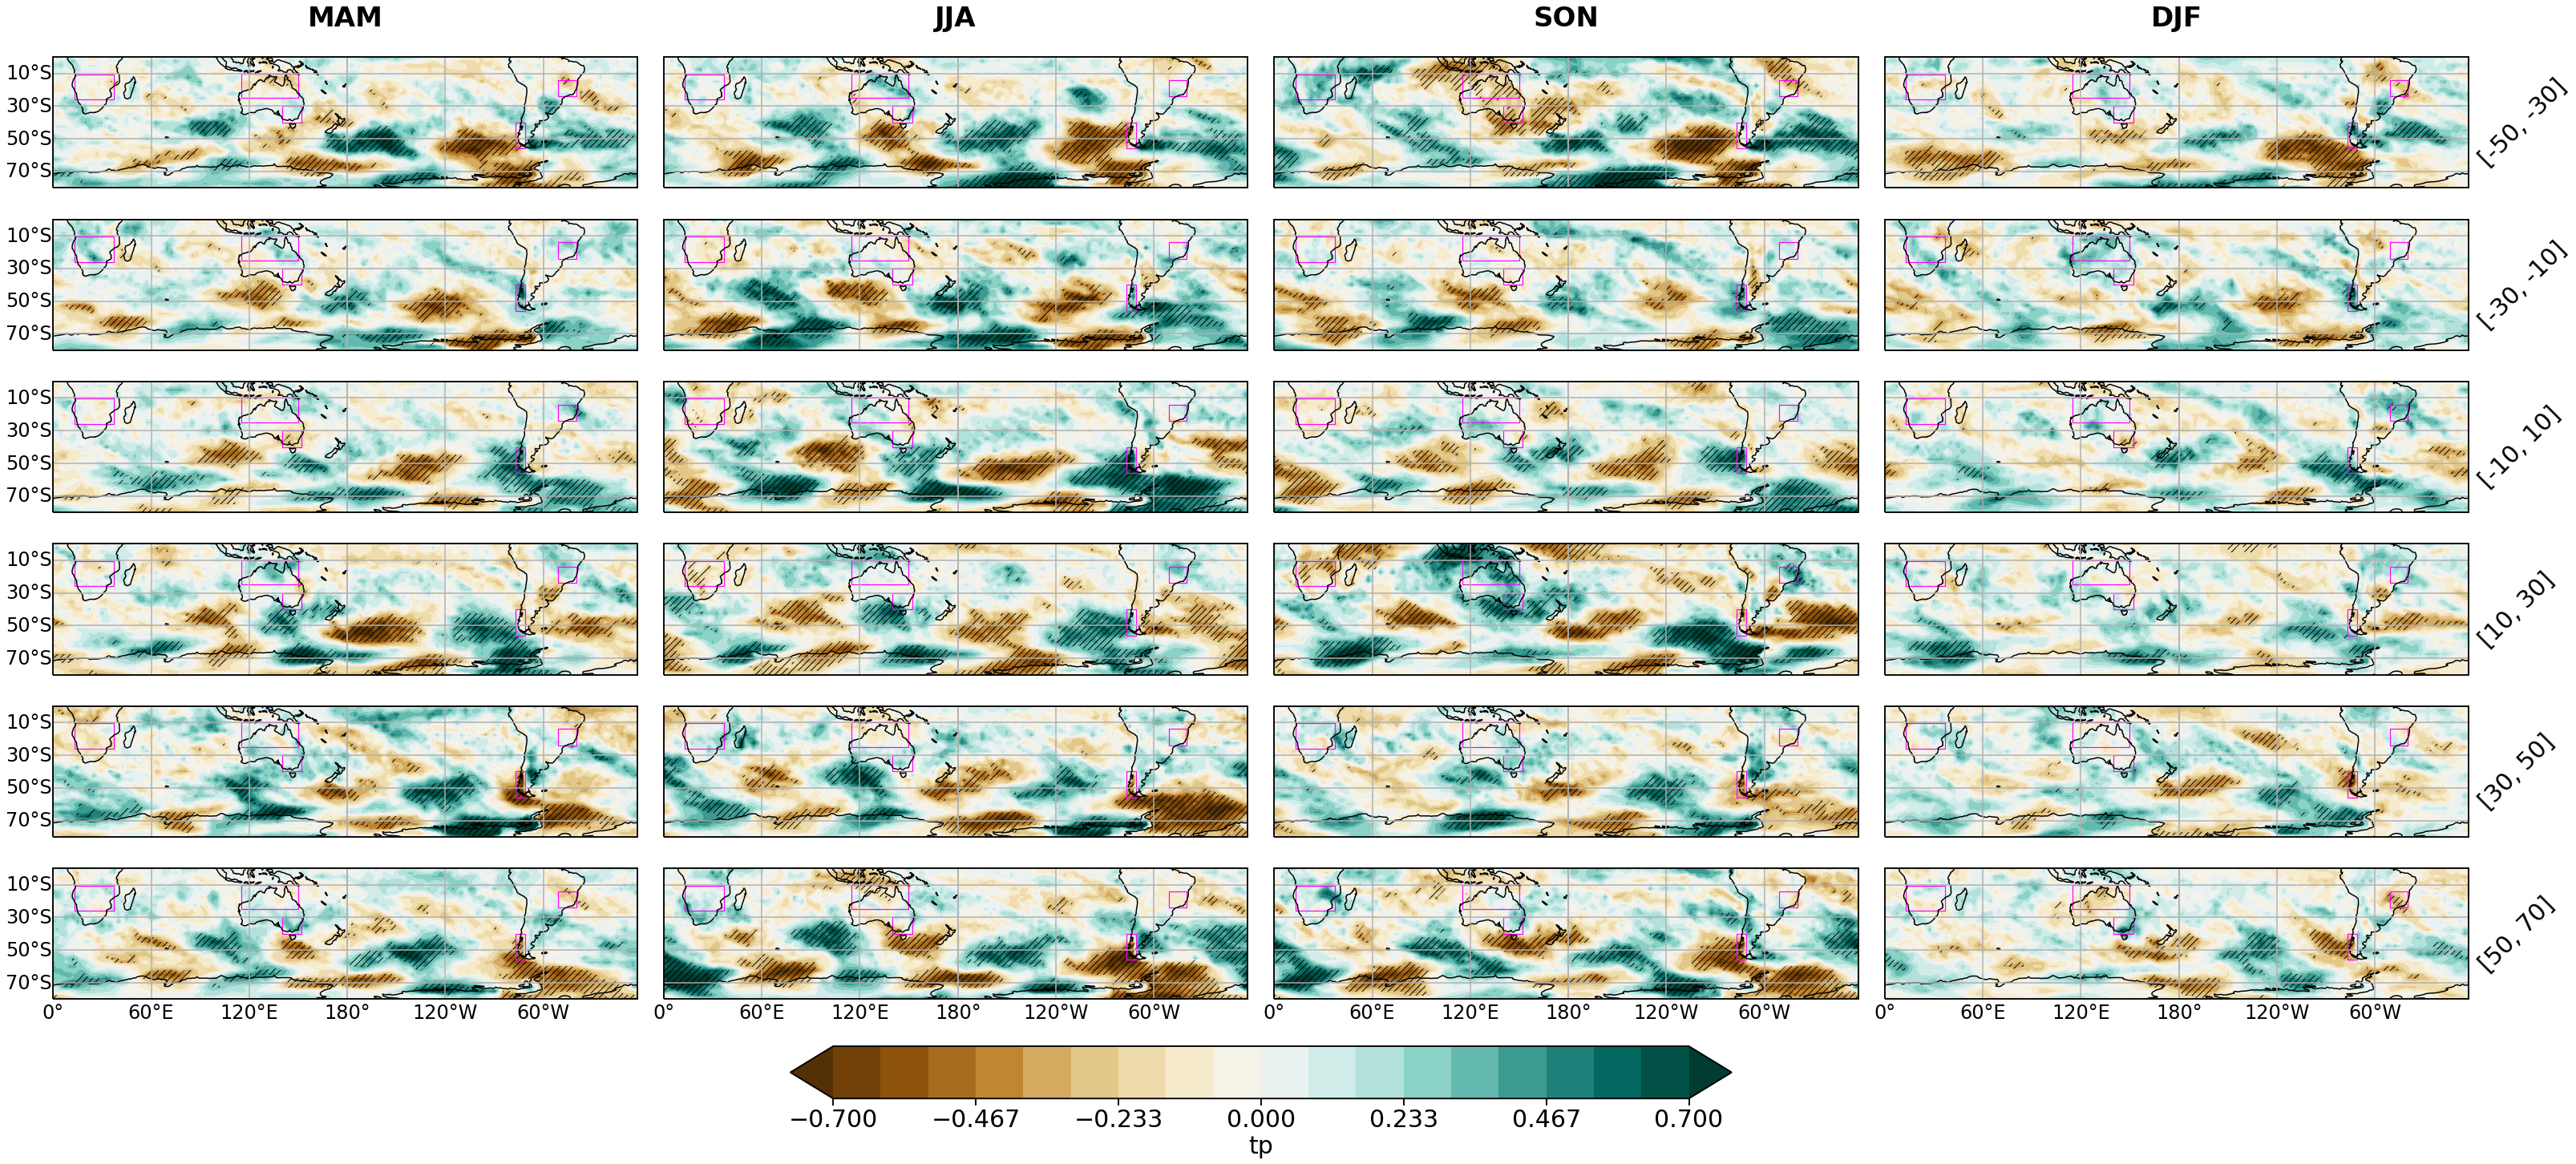

In [21]:
# PLOT W3 COMPOSITES ALL SEASONS

# Precipitation anomaly
levels = np.linspace(-0.7, 0.7, 19)
tpP1 = plot_by_phase_allseasons(tp_comp_, pval=0.11, levels=levels, cmap='BrBG' , regions=regions_tp)
#tpP1.savefig(f'{path_figs}tp_comp_.pdf', bbox_inches='tight', facecolor='white', transparent=False)

# Temperature anomaly
levels = np.linspace(-1.2, 1.2, 19)
t2mP1 = plot_by_phase_allseasons(t2m_comp_, pval=0.1101, levels=levels, regions=regions_t2m, var2=v_comp_.sel(pres=500))
#t2mP1.savefig(f'{path_figs}t2m_comp_.pdf', bbox_inches='tight', facecolor='white', transparent=False)

#### Figure 3

Barplots

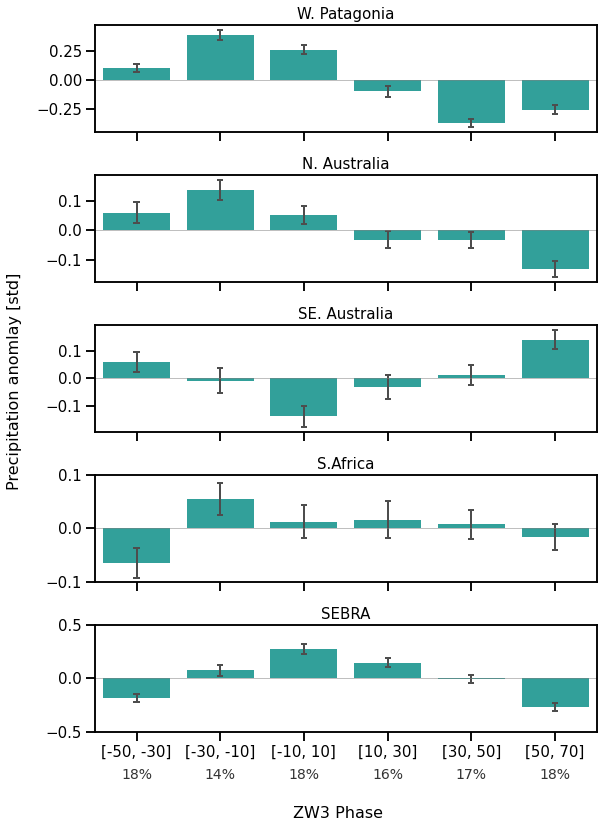

In [22]:
# compute wave-3 composites, keep time dim
s = 'DJF'
tp_comp = compose_on_w3(tp_roll_anom, phase, bins, amp=amp_std, amp_thresh=0.5, do_mean=False, season='DJF')
tp_comp['season'] = 'DJF'

# make barplot
bp = barplot(tp_comp, regions_tp, title='')

# save fig
#bp.savefig(f'{path_figs}barplot_tp_DJF.pdf', bbox_inches='tight', facecolor='white', transparent=False)

#### Figure 4

ZW3-based composites — Wet and Dry

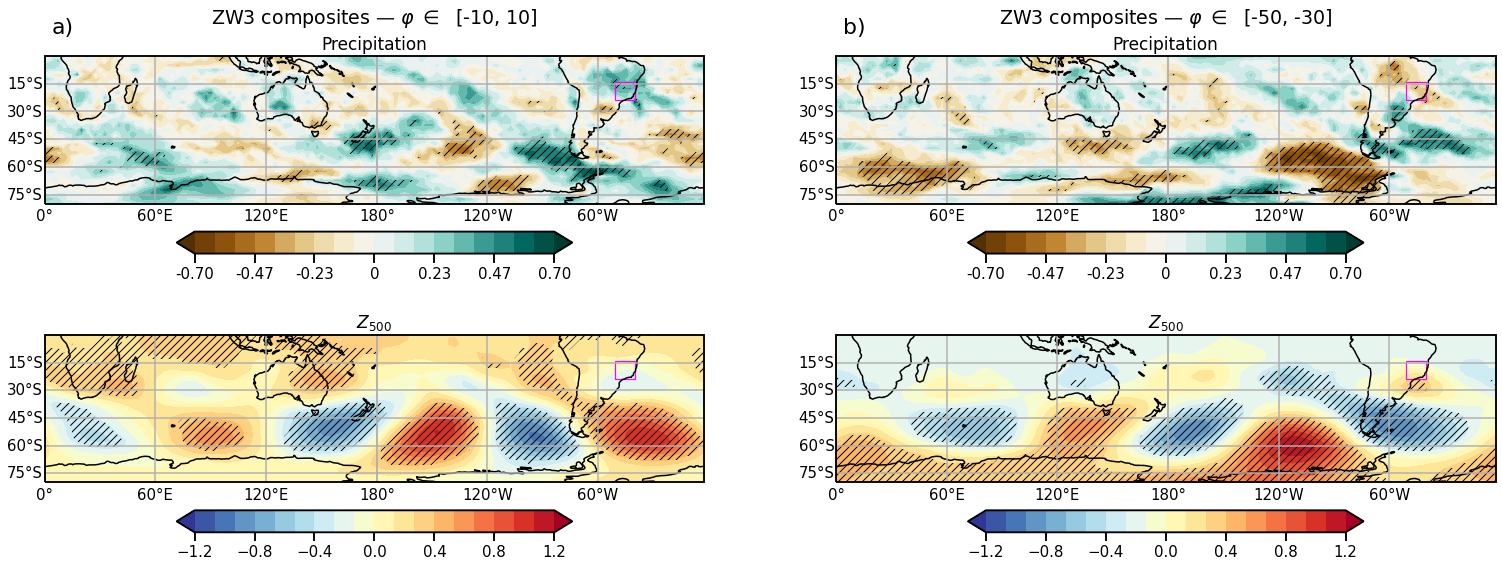

In [73]:
# plot wet and dry phases - ZW3 composites
w3_comp = plot_zw3_wetdry(tp_comp_, gp_comp_, pstar=0.11, regions=regs)

# save fig
#w3_comp.savefig(f'{path_figs}w3_comp.pdf', bbox_inches='tight', facecolor='white', transparent=False)

#### Figure 5

Precipitation-based composites — Wet and Dry

In [23]:
# compute

# 'Wet'
tp_pcomp_wet, tp_pvals_wet = compose_precip_regs(tp_roll_anom, regs, 'wet', V=Vtp_79)
gp_pcomp_wet, gp_pvals_wet = compose_precip_regs(gp_roll_anom, regs, 'wet', V=Vtp_79)

# 'Dry'
tp_pcomp_dry, tp_pvals_dry = compose_precip_regs(tp_roll_anom, regs, 'dry', V=Vtp_79)
gp_pcomp_dry, gp_pvals_dry = compose_precip_regs(gp_roll_anom, regs, 'dry', V=Vtp_79)

# concat and merge
tp_pcomp = xr.concat([tp_pcomp_wet, tp_pcomp_dry], dim='phase')
gp_pcomp = xr.concat([gp_pcomp_wet, gp_pcomp_dry], dim='phase')

tp_pvals = xr.concat([tp_pvals_wet, tp_pvals_dry], dim='phase')
gp_pvals = xr.concat([gp_pvals_wet, gp_pvals_dry], dim='phase')

tp_pcomp = xr.merge([tp_pcomp, tp_pvals])
gp_pcomp = xr.merge([gp_pcomp, gp_pvals])

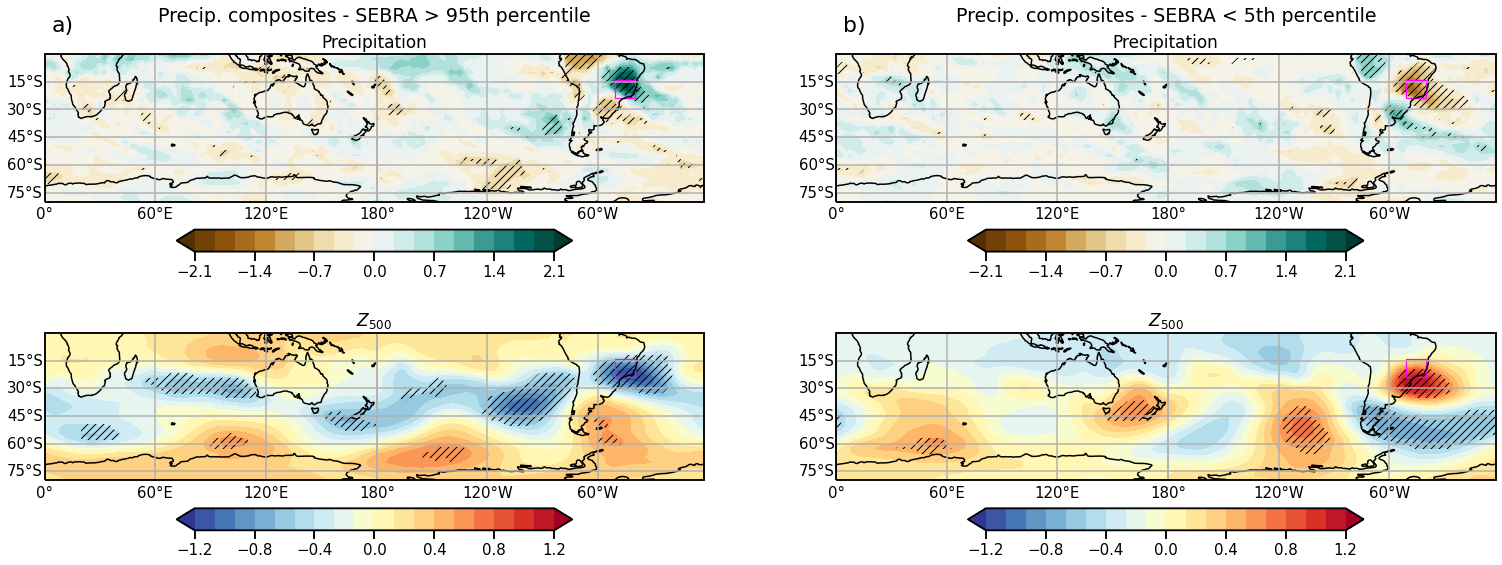

In [24]:
# plot wet and dry phases - Precip composites

pstar = 0.11
s = 'DJF'
reg = 'SEBRA'
plev = 500

pad = 0.12

var1 = tp_pcomp.sel(region=reg)
# significance
sig_mask_1 = var1.pval < pstar
# var to plot
var1 = var1.tp

var2 = gp_pcomp.sel(pres=plev).sel(region=reg)
# significance
sig_mask_2 = var2.pval < pstar
# var to plot
var2 = var2.z

levels1 = np.linspace(-2.1, 2.1, 19)
levels2 = np.linspace(-1.2, 1.2, 19)
sec = {'lat': slice(-80,0)}
lats = var1.sel(sec).lat
lons = var2.sel(sec).lon
transf = ccrs.PlateCarree()

nrows = 2
ncols = 2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(13*ncols, 4.7*nrows), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
ac.AddPanelLabels(axs[0,:], xpos=0.01, ypos=1.13, fontsize=22)

# loop over (the two) phases: 
for (extr,j) in zip(['wet', 'dry'], range(axs.shape[1])):

    #  "Wet" : [0,0] precip, [1,0] GPH
    #  "Dry" : [0,1] precip, [1,1] GPH
    ttl = '> 95th' if extr=='wet' else '< 5th'
    axs[0,j].set_title(f'Precip. composites - SEBRA {ttl} percentile', y=1.18, fontsize=19)
    
    cf1 = var1.sel(phase=extr).sel(sec).plot.contourf(ax=axs[0,j], levels=levels1, extend='both', cmap='BrBG', add_colorbar=False, transform=transf, add_labels=False)
    axs[0,j].contourf(lons, lats, sig_mask_1.sel(phase=extr).sel(sec), levels=[0,0.9,1.2], colors='none',  hatches=['', '///'], alpha=0, transform=transf)
    
    cf2 = var2.sel(phase=extr).sel(sec).plot.contourf(ax=axs[1,j], levels=levels2, extend='both', cmap='RdYlBu_r', add_colorbar=False, transform=transf, add_labels=False)
    axs[1,j].contourf(lons, lats, sig_mask_2.sel(phase=extr).sel(sec), levels=[0,0.9,1.2], colors='none',  hatches=['', '///'], alpha=0, transform=transf)
    
    axs[0,j].text(0.5, 1.02, 'Precipitation', ha='center', va='bottom', fontsize=17, transform=axs[0,j].transAxes)
    axs[1,j].text(0.5, 1.02, '$Z_{500}$', ha='center', va='bottom', fontsize=17, transform=axs[1,j].transAxes)
    
    for ax in axs[:,j].flatten():
        ax.coastlines()
        gls = ax.gridlines(draw_labels=True)
        gls.ylocator = mticker.MaxNLocator(6)
        gls.top_labels=False  
        gls.right_labels=False
        gls.xlabel_style = {'size': 15}
        gls.ylabel_style = {'size': 15}

        # boxes
        draw_boxes(ax, regs, transf)
    
    
    cb1 = fig.colorbar(cf1, ax=axs[0,j], orientation='horizontal', extend='both', fraction=0.1, aspect=18,
                 shrink=0.6, pad=pad)
    cb2 = fig.colorbar(cf2, ax=axs[1,j], orientation='horizontal', extend='both', fraction=0.1, aspect=18,
                 shrink=0.6, pad=pad)
    
    for cb in [cb1, cb2]:
        cb.ax.locator_params(nbins=8)
        cb.ax.tick_params(labelsize=15)

#fig.savefig(f'{path_figs}precip_comp.pdf', bbox_inches='tight', facecolor='white', transparent=False)

#### Figure 6

Conditional probability using ZW3 as prior information

In [26]:
# P(H|ZW3) for all seasons, many regions
# where H:= rainfall extreme in SEBRA

nstar = 30 if timescale=='30dRM' else 2  # set parmeter for min sample size

prob_H_ZW3 = []

for sam_thresh in [None, 0.5, -0.5]:  # index j

    # - - - WET - - - 

    prob_H_ZW3_wet = []

    for s in ['DJF']:#, 'MAM', 'JJA', 'SON']:

        prob_s = []

        for (r,area) in regs.items():
            p = p_H_ZW3(phase_da, bins, amp_std, n=nbins, box=area, extrm='wet', pct=0.95, samidx=sam, sam_thresh=sam_thresh, min_ssize=nstar, season=s)
            p['region'] = r
            prob_s.append(p)   

        prob_s = xr.concat(prob_s, dim='region')
        prob_s['season'] = s
        prob_H_ZW3_wet.append(prob_s)

    prob_H_ZW3_wet = xr.concat(prob_H_ZW3_wet, dim='season')
    prob_H_ZW3_wet['phase'] = 'wet'



    # - - - DRY - - -

    prob_H_ZW3_dry = []

    for s in ['DJF']:#, 'MAM', 'JJA', 'SON']:

        prob_s = []

        for (r,area) in regs.items():
            p = p_H_ZW3(phase_da, bins, amp_std, n=nbins, box=area, extrm='dry', pct=0.05, samidx=sam, sam_thresh=sam_thresh, min_ssize=nstar, season=s)
            p['region'] = r
            prob_s.append(p)   

        prob_s = xr.concat(prob_s, dim='region')
        prob_s['season'] = s
        prob_H_ZW3_dry.append(prob_s)

    prob_H_ZW3_dry = xr.concat(prob_H_ZW3_dry, dim='season')
    prob_H_ZW3_dry['phase'] = 'dry'


    prob_H_ZW3_j = xr.concat([prob_H_ZW3_wet, prob_H_ZW3_dry], dim='phase')
    prob_H_ZW3_j['sam_thresh'] = sam_thresh    
    prob_H_ZW3.append(prob_H_ZW3_j)

prob_H_ZW3 = xr.concat(prob_H_ZW3, dim='sam_thresh')

In [27]:
# P(H|ZW3-phase) for all seasons, many regions

Athresh = 0.5
prob_H_ZW3phase = []

for sam_thresh in [None, 0.5, -0.5]:  # index j

    # - - - -  WET  - - - - 

    prob_H_ZW3phase_wet = []

    for s in ['DJF']:#, 'MAM', 'JJA', 'SON']:

        prob_s = []

        for (r,area) in regs.items():
            p = p_H_ZW3phase(phase_da, bins, box=area, extrm='wet', pct=0.95, amp=amp_std,
                                 amp_thresh=Athresh, samidx=sam, sam_thresh=sam_thresh, wdw=wdw, season=s)
            p['region'] = r
            prob_s.append(p)   

        prob_s = xr.concat(prob_s, dim='region')
        prob_s['season'] = s
        prob_H_ZW3phase_wet.append(prob_s)

    prob_H_ZW3phase_wet = xr.concat(prob_H_ZW3phase_wet, dim='season')
    prob_H_ZW3phase_wet['phase'] = 'wet'

    # - - - -  DRY  - - - - 

    prob_H_ZW3phase_dry = []

    for s in ['DJF']:#, 'MAM', 'JJA', 'SON']:

        prob_s = []

        for (r,area) in regs.items():
            p = p_H_ZW3phase(phase_da, bins, box=area, extrm='dry', pct=0.05, amp=amp_std,
                                     amp_thresh=Athresh, samidx=sam, sam_thresh=sam_thresh, wdw=wdw, season=s)
            p['region'] = r
            prob_s.append(p)   

        prob_s = xr.concat(prob_s, dim='region')
        prob_s['season'] = s
        prob_H_ZW3phase_dry.append(prob_s)

    prob_H_ZW3phase_dry = xr.concat(prob_H_ZW3phase_dry, dim='season')
    prob_H_ZW3phase_dry['phase'] = 'dry'
    
    # - - - join WET and DRY - - -
    prob_H_ZW3phase_j = xr.concat([prob_H_ZW3phase_wet, prob_H_ZW3phase_dry], dim='phase')
    prob_H_ZW3phase_j['sam_thresh'] = sam_thresh
    prob_H_ZW3phase.append(prob_H_ZW3phase_j)
    
prob_H_ZW3phase = xr.concat(prob_H_ZW3phase, dim='sam_thresh')

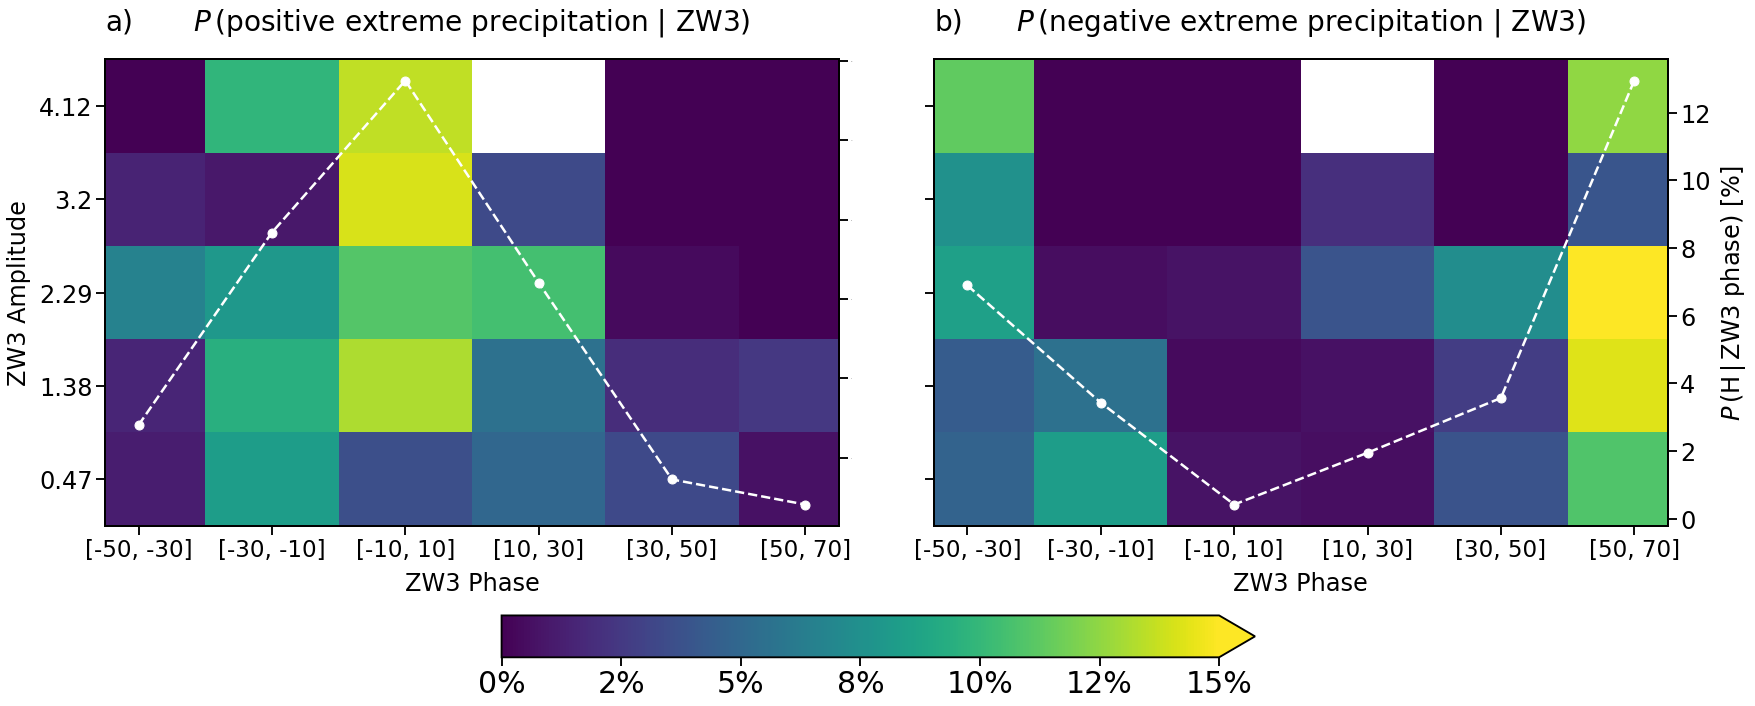

In [28]:
# PLOT PROBABILITY BOTH PHASES "WET" and "DRY"

def ttl(ph):
    if ph=='wet':
        ttl = '$P\,($positive extreme precipitation | ZW3$)$'
    else:
        ttl = '$P\,($negative extreme precipitation | ZW3$)$'
    return ttl
        

reg = 'SEBRA'
s = 'DJF'
samthresh = None

# vars (xr.da) to plot
prob = prob_H_ZW3.sel(sam_thresh=samthresh).sel(season=s).sel(region=reg)
prob_phase = prob_H_ZW3phase.sel(sam_thresh=samthresh).sel(season=s).sel(region=reg) * 100

# fig/plot params
nrows = 1
ncols = 2
clr2 = 'white'
pad = 0.12

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14*ncols, 11), sharey=True)
fig.subplots_adjust(wspace=0.13)
ac.AddPanelLabels(axs, xpos=0.0, ypos=1.05, fontsize=fs2-2)


# loop over (the two) phases: 
for (ph,j) in zip(['wet', 'dry'], range(axs.shape[0])):
    axs[j].set_title(f'{ttl(ph)}', y=1.05, fontsize=fs2-2)
    prob_ph = prob.sel(phase=ph).dropna(dim='amp_bin', how='all')
    cm = axs[j].pcolormesh(prob_ph.bin.data, prob_ph.amp_bin.data.astype('str'), prob_ph.data, vmax=0.15)
    ax2 = axs[j].twinx()
    prob_phase.sel(phase=ph).plot(ax=ax2, marker='o', ms=9., c=clr2, ls='--',lw=2.5, _labels=False)
    axs[j].set_xlabel(f'ZW3 Phase', fontsize=fs3, labelpad=10.)
    if ph=='dry':
        ax2.yaxis.set_tick_params(labelsize=fs3)
    else:
        ax2.yaxis.set_tick_params(labelsize=0)
    
# comon y-axis label
axs[0].set_ylabel('ZW3 Amplitude', fontsize=fs3, labelpad=8.)
ax2.set_ylabel(r'$P\,($H$\,$|$\,$ZW3 phase$)$ [%]', fontsize=fs3, labelpad=8.5)

for ax in axs.flatten():
    ax.xaxis.set_tick_params(labelsize=fs3-1)#, fontstretch='semi-condensed')
    ax.yaxis.set_tick_params(labelsize=fs3)

cb = fig.colorbar(cm, ax=axs.ravel().tolist(), orientation='horizontal', extend='max', fraction=0.07, aspect=18,
             shrink=0.7, pad=0.15)
cb.ax.locator_params(nbins=6)
cb.ax.tick_params(labelsize=fs4)
# Define a function to format the colorbar labels
def percentage_formatter(x, pos):
    return f'{x * 100:.0f}%'
# Set the formatter for the colorbar
cb.formatter = mticker.FuncFormatter(percentage_formatter)
cb.update_ticks()

#fig.savefig(f'{path_figs}p_h_zw3.pdf', bbox_inches='tight', facecolor='white', transparent=False)

#### Figure 7, Figure 8

Probability conditioned on Index and ZW3

In [31]:
## COMPUTE PROBABILITIES

# Need to: match time dim to compute w3 for enso and iod
# just because when resampling nino/iod index dates in 'time'
# dim result different. nino/iod starts in 1959-01-21 whereas
# v_roll_anom starts in 1959-01-01
if timescale=='monthly':
    v_roll_anom_nino = v_roll_anom.sel(time=slice('1959', nino.time.data[-1]))
    nino['time'] = v_roll_anom_nino.time
    iod['time'] = v_roll_anom_nino.time
else:
    v_roll_anom_nino = v_roll_anom.sel(time=slice(nino.time.data[0], nino.time.data[-1]))
# compute wave 3
sig_nino = v_roll_anom_nino.sel(pres=500).sel(lat=slice(-70,-40)).mean('lat')
wave3_nino, amp_nino, phase_nino = get_harmonic(sig_nino, 3)
# shift phase
phase_nino =  np.where(phase_nino<-50, phase_nino+120, phase_nino)
phase_nino_da =  xr.DataArray(phase_nino, dims='time', coords={'time' : sig_nino.time.data}, name='wave phase')
# standardised amp
amp_nino_da = xr.DataArray(amp_nino, dims='time', coords={'time' : sig_nino.time.data}, name='wave amplitude')
amp_nino_std = amp_nino_da.groupby('time.dayofyear') / amp_nino_da.groupby('time.dayofyear').std()

In [32]:
# P (H | Index)
# Using ZW3 amplitude threshold 
nbins = len(bins)
s = 'DJF'
reg = 'SEBRA'
Athresh = 0.5

# uncomment here the selected phase ('wet' or 'dry) with the pct
# comment the other one
ph = 'wet'
pct = 0.95

# ph = 'dry'
# pct = 0.05

nstar = 30 if timescale=='30dRM' else 5  # set parmeter for min sample size

# Probability of H given Index phase
prob_H_SAM = p_H_idx(sam, n=nbins, box=regs[reg], extrm=ph, pct=pct, min_ssize=nstar, wdw=wdw, season=s)
prob_H_Nino = p_H_idx(nino, n=nbins, box=regs[reg], extrm=ph, pct=pct, min_ssize=nstar, wdw=wdw, season=s)
prob_H_IOD = p_H_idx(iod, n=nbins, box=regs[reg], extrm=ph, pct=pct, min_ssize=nstar, wdw=wdw, season=s)
prob_H_PSA1 = p_H_idx(psa1, n=nbins, box=regs[reg], extrm=ph, pct=pct, min_ssize=nstar, wdw=wdw, season=s)
prob_H_PSA2 = p_H_idx(psa2, n=nbins, box=regs[reg], extrm=ph, pct=pct, min_ssize=nstar, wdw=wdw, season=s)

# Probability of H given ZW3 and Index
nstar2 = 30 if timescale=='30dRM' else 5

prob_H_ZW3phase_SAM = p_H_ZW3phase_idx(phase, bins, sam, nbins, box=regs[reg], extrm=ph, pct=pct, amp=amp_std, amp_thresh=Athresh, min_ssize=nstar2, season=s)
prob_H_ZW3phase_Nino = p_H_ZW3phase_idx(phase_nino, bins, nino, nbins, box=regs[reg], extrm=ph, pct=pct, amp=amp_nino_std, amp_thresh=Athresh, min_ssize=nstar2, season=s)
prob_H_ZW3phase_IOD = p_H_ZW3phase_idx(phase_nino, bins, iod, nbins, box=regs[reg], extrm=ph, pct=pct, amp=amp_nino_std, amp_thresh=Athresh, min_ssize=nstar2, season=s)
prob_H_ZW3phase_PSA1 = p_H_ZW3phase_idx(phase, bins, psa1, nbins, box=regs[reg], extrm=ph, pct=pct, amp=amp_std, amp_thresh=Athresh, min_ssize=nstar2, season=s)
prob_H_ZW3phase_PSA2 = p_H_ZW3phase_idx(phase, bins, psa2, nbins, box=regs[reg], extrm=ph, pct=pct, amp=amp_std, amp_thresh=Athresh, min_ssize=nstar2, season=s)

In [34]:
# Plotting params

from matplotlib.gridspec import GridSpec
import matplotlib.transforms as transforms

sns.set_context("talk")

#Fontsizes
fs1 = 34  # column title
fs2 = 30  # panel/subplot title
fs3 = 24  # axes labels
fs4 = 30  # colorbar

cbar_params = {'orientation':'horizontal', 'extend':'both', 'fraction':0.05, 'shrink':1.0, 'aspect':18, 'pad':0.045}

**Figure 7**

phase = wet,  pct = 0.95
region = SEBRA


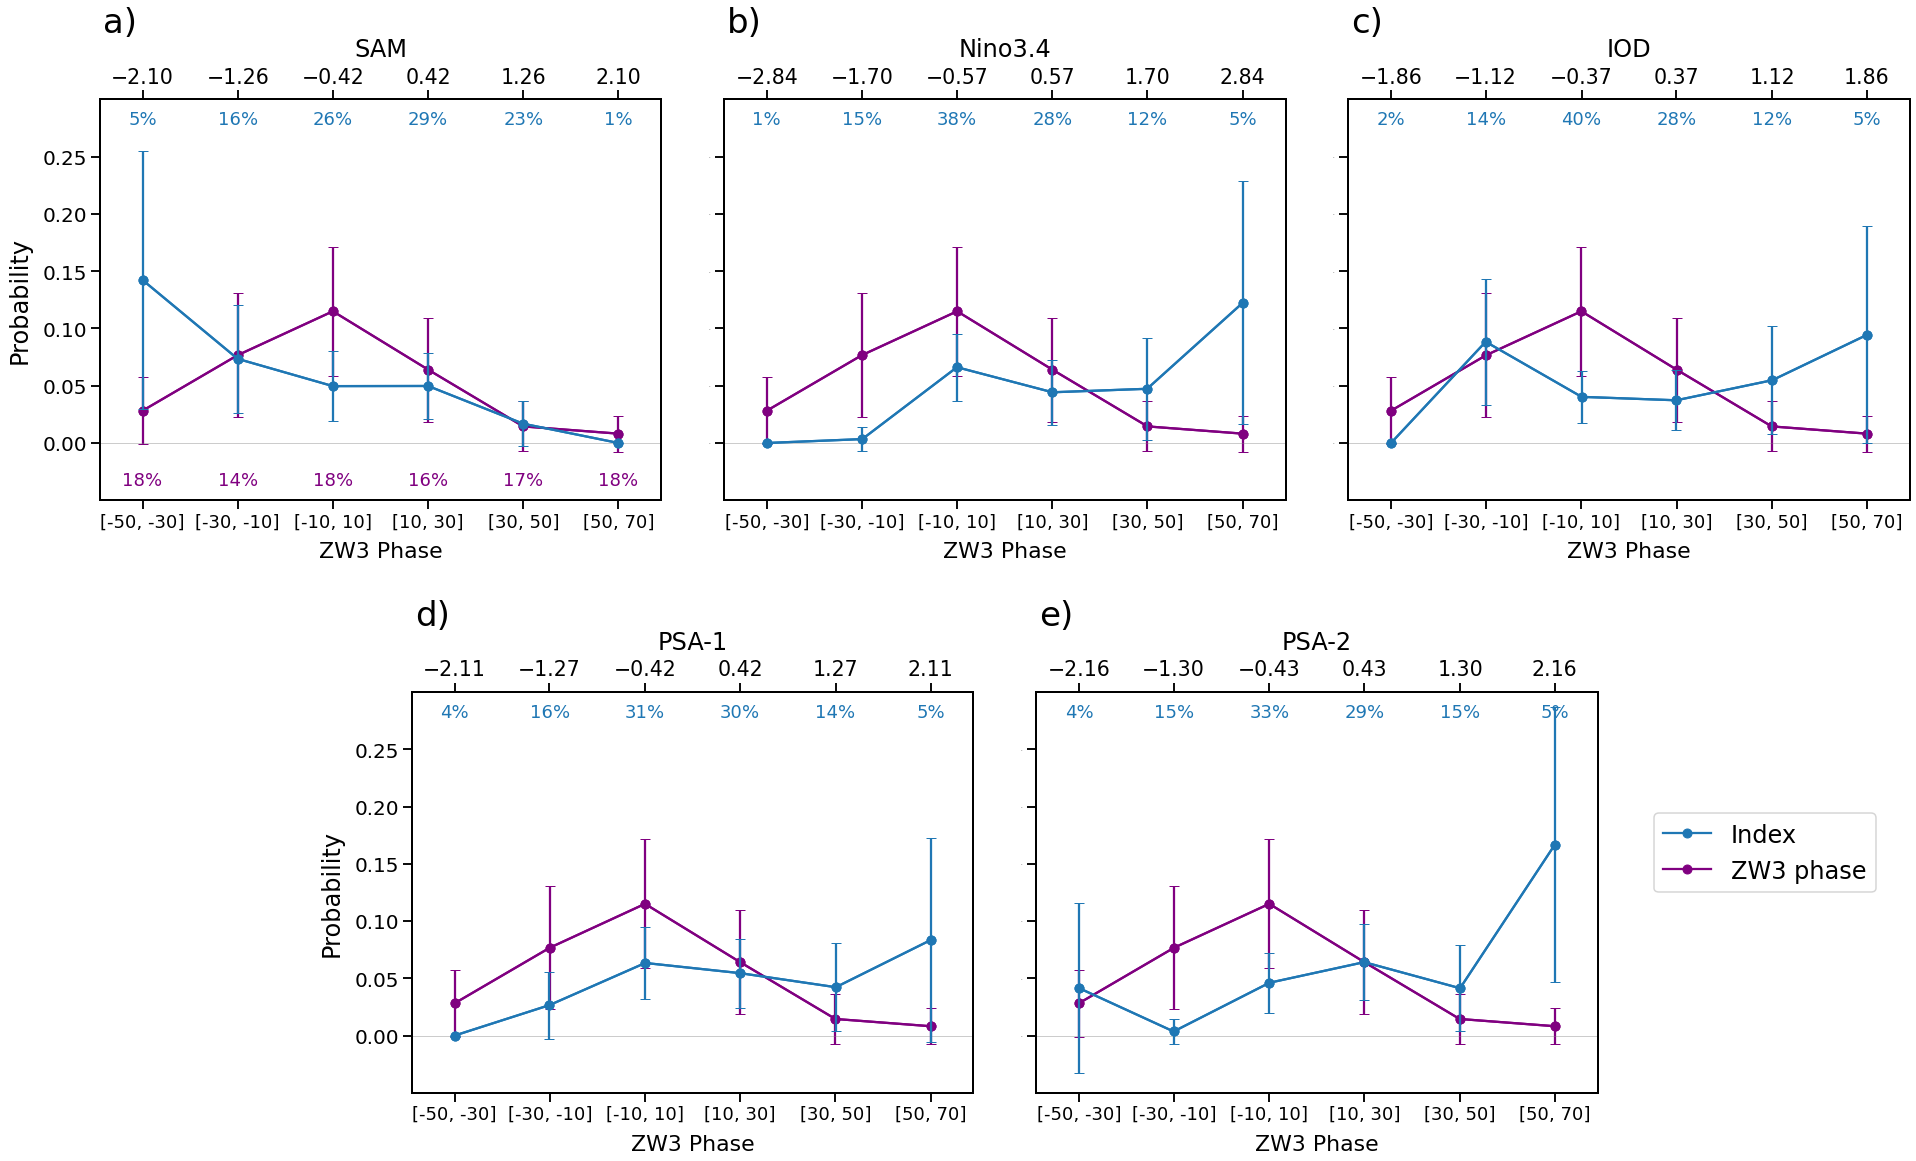

In [35]:
print(f'phase = {ph},  pct = {pct}')
print(f'region = {reg}')

# prob given ZW3 phase to compare 
da1 = prob_H_ZW3phase.sel(sam_thresh=None).sel(phase=ph).sel(season=s).sel(region=reg)
dalist = [prob_H_SAM, prob_H_Nino, prob_H_IOD, prob_H_PSA1, prob_H_PSA2]

# freqs wave3 phases
freqs_w3 = 100 * (da1.n / da1.N).values

ncols = 3
nrows = 2
fig = plt.figure(figsize=(8.8*ncols, 8.0*nrows))            
ax1 = plt.subplot2grid((2, 6), (0, 0), colspan=2)
ax2 = plt.subplot2grid((2, 6), (0, 2), colspan=2, sharey = ax1)
ax3 = plt.subplot2grid((2, 6), (0, 4), colspan=2, sharey = ax1)
ax4 = plt.subplot2grid((2, 6), (1, 1), colspan=2)
ax5 = plt.subplot2grid((2, 6), (1, 3), colspan=2, sharey = ax4)
axes = [ax1,ax2,ax3,ax4,ax5]
ac.AddPanelLabels(axes, xpos=0.005, ypos=1.15, fontsize=fs1)
plt.tight_layout(h_pad=4,w_pad=0.6)

for (da,ax) in zip(dalist, axes):

    l1 = da1.plot(ax=ax, marker='o', color='purple', label='ZW3 phase', _labels=False)
    ax.errorbar(da1.bin, da1.values, yerr=da1.SE, fmt='o-', capsize=5.0, c='purple')
    ax.axhline(y=0.0, lw=1, c='grey', alpha=0.4)
    twin = ax.twiny()
    l2 = twin.plot(da.idx_bin, da.values, marker='o', label=f'Index')# label=f'given {da.index.data}')
    twin.errorbar(da.idx_bin, da.values, yerr=da.SE, fmt='o-', capsize=5.0, c='tab:blue')
    # add margins
    ax.margins(x=0.09, y=0.08)
    twin.margins(x=0.09, y=0.08)
    
    # axes labels
    ax.set_xlabel('ZW3 Phase', fontsize=fs3-2, labelpad=10.5)
    twin.set_xlabel(da.index.data, fontsize=fs3,labelpad=10.6, fontweight='medium')
    twin.set_xticks(da.idx_bin.values)
    ax.xaxis.set_tick_params(labelsize=fs3-6)
    twin.xaxis.set_tick_params(labelsize=fs3-3.5)
    # y ticks
    ax.set_ylim(-0.05, 0.30)
    ax.set_yticks([0.0,0.05,0.10,0.15,0.20, 0.25])
    ax.yaxis.set_tick_params(labelsize=fs3-4)
        
    # frequencies
    freqs = (da.n / da.n.sum()).values * 100
    trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
    for x, freq in enumerate(freqs):
        ax.text(x, 0.95, f'{freq:.0f}%', ha='center', va='center', fontsize=18, c='C0', transform=trans, fontweight='roman')
    if ax==ax1:
        for x, freq in enumerate(freqs_w3):
            ax.text(x, 0.05, f'{freq:.0f}%', ha='center', va='center', fontsize=18, c='purple', transform=trans, fontweight='roman')
    
# for the legend
lns = l2+l1
labels = [l.get_label() for l in lns]
ax.legend(lns, labels, loc=(1.1,0.5), fontsize=fs3)  
    
for ax in [ax1, ax4]:
    ax.set_ylabel('Probability', fontsize=fs3, labelpad=11.5)  
for ax in [ax2, ax3, ax5]:
    ax.yaxis.set_tick_params(labelsize=0)
    
#fig.savefig(f'{path_figs}prob_h_index_{ph}.pdf', bbox_inches='tight', facecolor='white', transparent=False)

**Figure 8**

phase = wet,  pct = 0.95
region = SEBRA


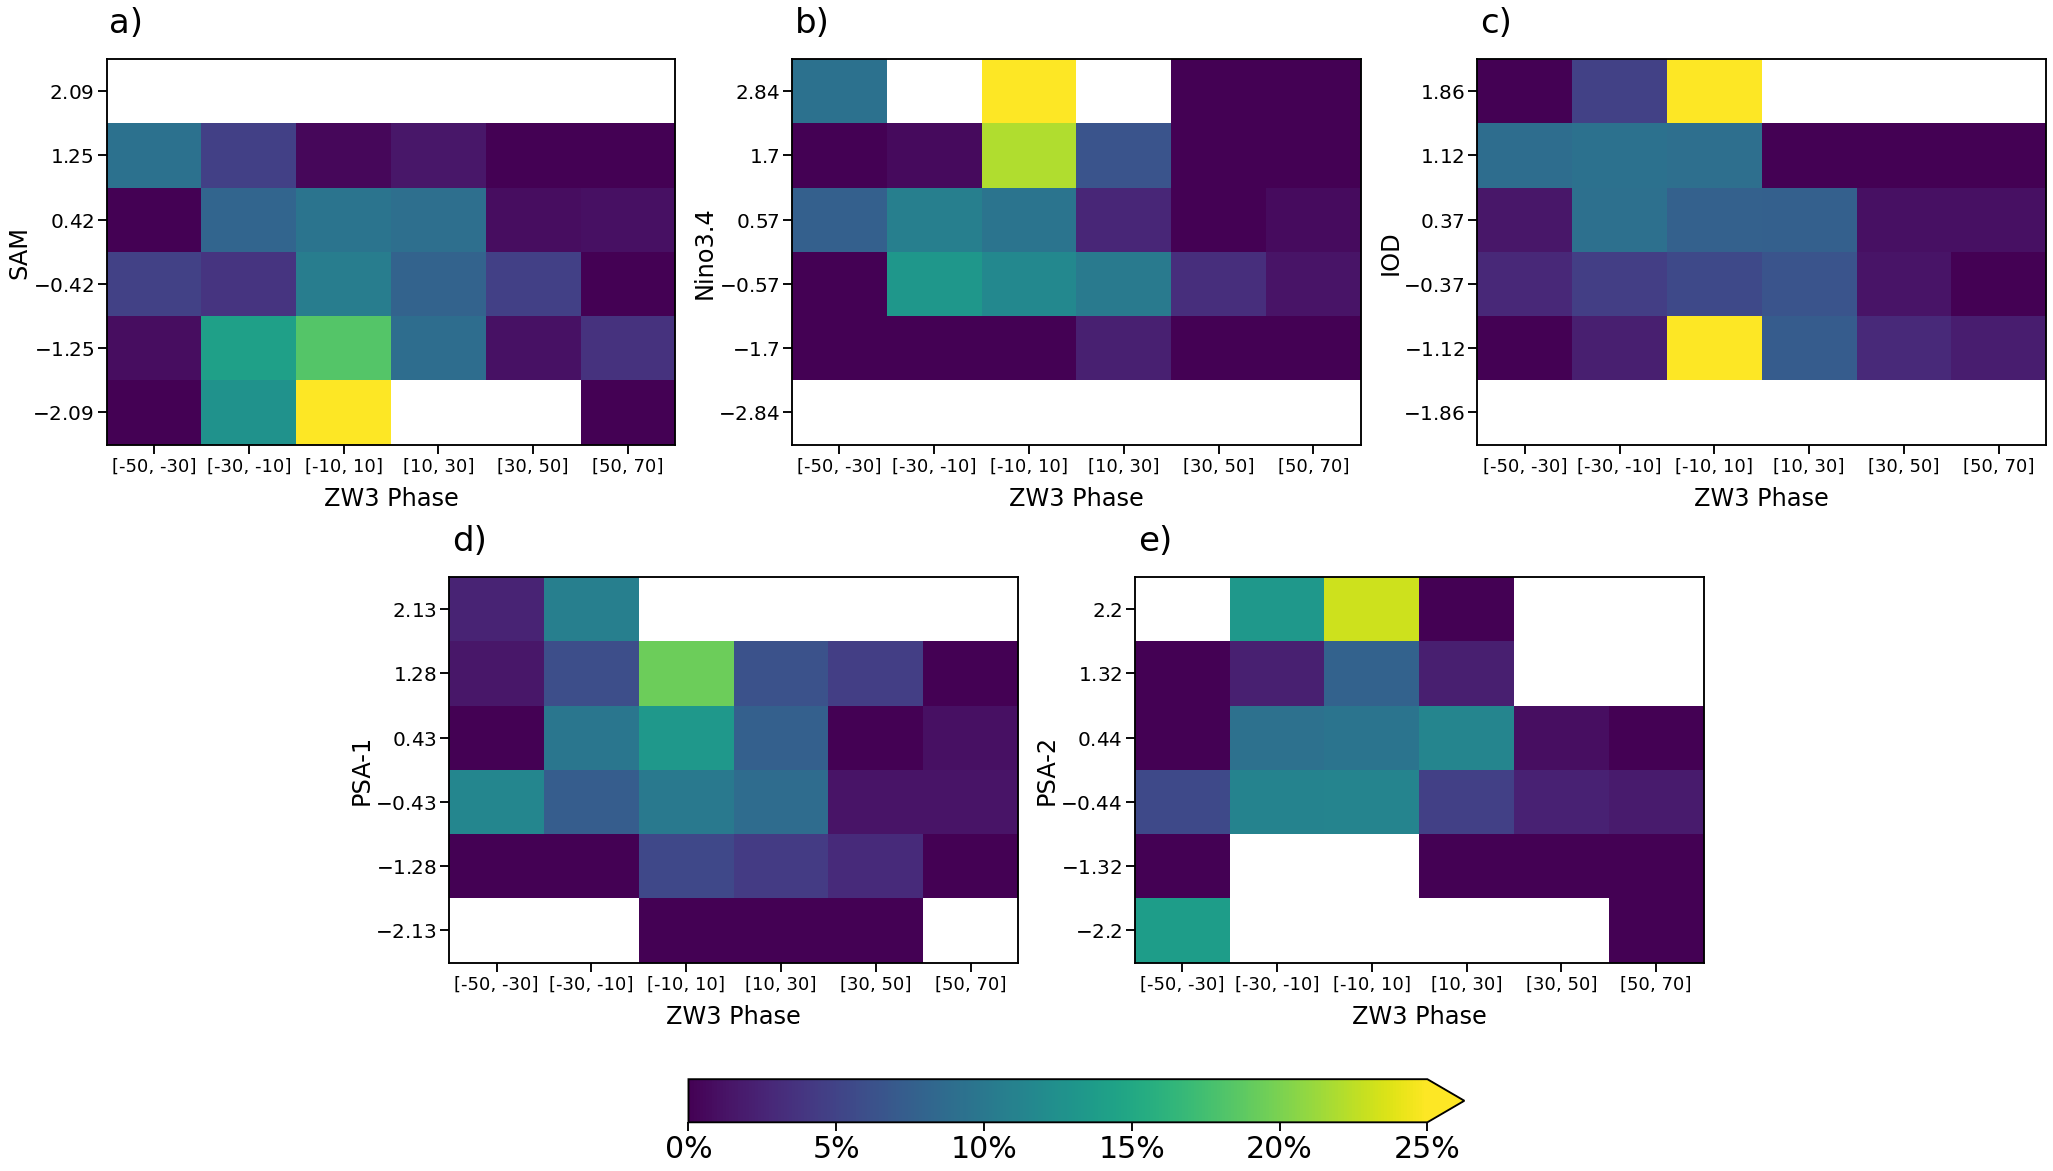

In [36]:

# - - - - - - - - - - - - - - 
# FIG 2

print(f'phase = {ph},  pct = {pct}')
print(f'region = {reg}')

dalist2 = [prob_H_ZW3phase_SAM, prob_H_ZW3phase_Nino, prob_H_ZW3phase_IOD, prob_H_ZW3phase_PSA1, prob_H_ZW3phase_PSA2]

ncols = 3
nrows = 2
fig = plt.figure(figsize=(9.4*ncols, 11*nrows))            
ax1 = plt.subplot2grid((2, 6), (0, 0), colspan=2)
ax2 = plt.subplot2grid((2, 6), (0, 2), colspan=2)
ax3 = plt.subplot2grid((2, 6), (0, 4), colspan=2)
ax4 = plt.subplot2grid((2, 6), (1, 1), colspan=2)
ax5 = plt.subplot2grid((2, 6), (1, 3), colspan=2)
axes = [ax1,ax2,ax3,ax4,ax5]
ac.AddPanelLabels(axes, xpos=0.005, ypos=1.05, fontsize=fs1)
plt.tight_layout(h_pad=7,w_pad=3.6)
#fig.subplots_adjust(wspace=0.5)

for (da,ax) in zip(dalist2, axes):

    x = da.bin.data
    y = da.idx_bin.data.astype('str')
    cm = ax.pcolormesh(x, y, da.data, vmin=0.0, vmax=0.25)
    ax.set_xlabel('ZW3 Phase', fontsize=fs3, labelpad=11.)
    ax.set_ylabel(da.index.data, fontsize=fs3, labelpad=1.)
    # Use FixedLocator to set the y-tick positions
    ytick_locs = np.arange(len(da.idx_bin.values))
    ax.yaxis.set_major_locator(mticker.FixedLocator(ytick_locs))
    # Use FixedFormatter to set the y-tick labels
    ytick_labels = [f'${label}$' for label in da.idx_bin.values]
    ax.yaxis.set_major_formatter(mticker.FixedFormatter(ytick_labels))
    ax.xaxis.set_tick_params(labelsize=fs3-6)
    ax.yaxis.set_tick_params(labelsize=fs3-4)

cb = fig.colorbar(cm, ax=axes, orientation='horizontal', extend='max', fraction=0.3, shrink=0.4, pad=0.08, aspect=18,)
#cb.ax.locator_params(nbins=8)
cb.ax.tick_params(labelsize=fs4)
# Define a function to format the colorbar labels
def percentage_formatter(x, pos):
    return f'{x * 100:.0f}%'
# Set the formatter for the colorbar
cb.formatter = mticker.FuncFormatter(percentage_formatter)
cb.update_ticks()

#fig.savefig(f'{path_figs}prob_h_zw3_index_{ph}.pdf', bbox_inches='tight', facecolor='white', transparent=False)

#### Figure 9 
SST composites comparison

##### Goyal ZW3 Index

In [38]:
## Code (within '----' lines) taken from Goyal et al. 2022
# -----------------------------------------------------------------------------
import scipy as sc
from eofs.standard import Eof

# Subsample data to only consider meridional winds at 500 hPa and from 40S - 70S and then calculate monthly anomalies

# Compute GPH (not standardized) anomaly for Goyal index calculation
v500 = (v_roll.groupby('time.dayofyear') - v_roll.groupby('time.dayofyear').mean()).sel(pres=500, lat=slice(-70,-40))

# Carry out the EOFs

lat    = v500.lat
coslat = np.cos(np.deg2rad(lat.values)).clip(0.,1.)
wgts   = np.sqrt(coslat)[...,np.newaxis]
solver = Eof(v500.values, weights=wgts)
eof    = solver.eofsAsCovariance(neofs=6)
pcs    = solver.pcs(npcs=6, pcscaling=1)
var    = solver.varianceFraction()

# Calculate the ZW3 magnitude and phase indices

zw3magnitude_index = (pcs[:,0]**2 + pcs[:,1]**2)**0.5

zw3phase_index = np.zeros(len(v500[:,0,0])) * np.nan

for i in range(len(v500[:,0,0])):
    if((pcs[i,0]>0) and (pcs[i,1]>0)):
        zw3phase_index[i] = np.arctan(pcs[i,1] / pcs[i,0]) * 180 / (np.pi)
    elif((pcs[i,0]<0) and (pcs[i,1]>0)):
        zw3phase_index[i] = (np.arctan(pcs[i,1] / pcs[i,0]) * 180 / (np.pi)) + 180
    elif((pcs[i,0]>0) and (pcs[i,1]<0)):
        zw3phase_index[i] = (np.arctan(pcs[i,1] / pcs[i,0]) * 180 / (np.pi))
    elif((pcs[i,0]<0) and (pcs[i,1]<0)):
        zw3phase_index[i] = (np.arctan(pcs[i,1] / pcs[i,0]) * 180 / (np.pi)) - 180

# Save all variables in an xarray (can be then exported to netcdf files directly by using .to_netcdf function)

magnitude_index = xr.DataArray(zw3magnitude_index, coords=[v500.time], name='zw3index_magnitude')
phase_index     = xr.DataArray(zw3phase_index, coords=[v500.time], name='zw3index_phase')
pc1             = xr.DataArray(pcs[:,0], coords=[v500.time], name='pc1')
pc2             = xr.DataArray(pcs[:,1], coords=[v500.time], name='pc2')
# -----------------------------------------------------------------------------

In [39]:
# make 6 phase bins
bins_goyal = [[0,60], [60, 120], [120, 180], [-180,-120], [-120, -60], [-60,0]] 

# composite on G22-ZW3 phase
lags = np.arange(0,1,10)

# skt (SST)
skt_comp_g = []
for s in ['DJF']:#, 'MAM', 'JJA', 'SON']:
    skt_comp_s = lag_compose_on_w3(skt_roll_anom, zw3phase_index, zw3magnitude_index, bins_goyal, lags, V=Vtp_79, season=s)
    skt_comp_s['stdd'] = skt_comp_s['skt'] 
    skt_comp_s['season'] = s 
    skt_comp_g.append(skt_comp_s)
skt_comp_g = xr.concat(skt_comp_g, dim='season')

##### Fourier ZW1

In [40]:
# Get Fourier wave-1
signal1 = (v_roll.groupby('time.dayofyear') - v_roll.groupby('time.dayofyear').mean()).sel(pres=500).sel(lat=slice(-70,-40)).mean('lat')  # signal to decompose
wave1, amp1, phase1 = get_harmonic(signal1, 1)

# make 6 phase bins
bins_w1 = [[0,60], [60, 120], [120, 180], [-180,-120], [-120, -60], [-60,0]] 

# composite on ZW1
skt_comp_w1 = []
for s in ['DJF']:#, 'MAM', 'JJA', 'SON']:
    skt_comp_s = lag_compose_on_w3(skt_roll_anom, phase1, amp1, bins_w1, lags, V=Vtp_79, season=s)
    skt_comp_s['stdd'] = skt_comp_s['skt']
    skt_comp_s['season'] = s 
    skt_comp_w1.append(skt_comp_s)
skt_comp_w1 = xr.concat(skt_comp_w1, dim='season')

**Figure 9**

In [41]:
def plot_SSTs(pval=0.10, levels=np.linspace(-1.0, 1.0, 19), cmap=None, regions=None, var2=None):
    """ Plot SST composites for: ZW3 as defined in this study (Fourier analysis), 
        ZW3 as defined by Goyal et al. 2022 (G22), and ZW1 (Fourier analysis).
    """
    
    import matplotlib.ticker as mticker
    
    # var to plot
    def var1(da):
        sig_mask1 = da.sel(lag=0).pval < pval
        var1 = da.sel(lag=0).stdd 
        return var1, sig_mask1
  
    dalist = [skt_comp_, skt_comp_g, skt_comp_w1]
    danames = ['Fourier ZW3', 'Goyal ZW3', 'Fourier ZW1']
    
    s = 'DJF'
    sec = {'lat': slice(-80,0)}
    transf = ccrs.PlateCarree()
    nrows = 6
    ncols = 3
    [ypos, pad] = [0.91, 0.05]
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14*ncols, 4.5*nrows), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, sharex=True, sharey=True)
    ac.AddPanelLabels(axs[0,:], xpos=0.01, ypos=1.25, fontsize=fs1)
    
    # loop over [Fourier W3, G22 index, Fourier W1]
    for (da,j,name) in zip(dalist, range(axs.shape[1]), danames):
        axs[0,j].set_title(f'{name}', y=1.3, fontsize=fs1, weight='medium')
        
        # loop over phase bin (rows)
        for b,ax in enumerate(axs[:,j].flatten()):

            # bin label
            bin_lbl = str(da.isel(bin=b).bin.data)
            
            # get var and sigmask
            var, sig_mask = var1(da)
            lats = var.sel(sec).lat
            lons = var.sel(sec).lon

            # plot var1
            cf = var.sel(season=s).isel(bin=b).sel(sec).plot.contourf(ax=ax, levels=levels, extend='both', cmap=cmap,  
                                                add_colorbar=False, transform=transf, add_labels=False)
            # overlay hatching where significant
            ax.contourf(lons, lats, sig_mask.sel(season=s).isel(bin=b).sel(sec), levels=[0,0.9,1.2], 
                            colors='none', hatches=['', '///'], alpha=0, transform=transf)
            ax.text(0.5, 1.05, f'{bin_lbl}', ha='center', va='bottom', fontsize=fs2-1, weight='medium', transform=ax.transAxes)
            ax.coastlines()
            gls = ax.gridlines(crs=ccrs.PlateCarree())
            gls.ylocator = mticker.MaxNLocator(4)
            gls.ylocator = mticker.FixedLocator([-70, -50, -30, -10, 0])
            if j==0:
                gls.left_labels = True
            if b==nrows-1:
                gls.bottom_labels = True
            gls.xlabel_style = {'size': fs3}
            gls.ylabel_style = {'size': fs3}

            # add regions boxes
            if regions is not None:
                draw_boxes(ax, regions, transf)
                
    plt.subplots_adjust(wspace=0.05)

    cb = fig.colorbar(cf, ax=axs.ravel().tolist(), orientation='horizontal', extend='both', fraction=0.04, aspect=18,
             shrink=0.8, pad=0.05)
    cb.ax.locator_params(nbins=8)
    cb.set_label(label='SKT' , size=fs4)
    cb.ax.tick_params(labelsize=fs4)
    
    return fig

In [2]:
levels = np.linspace(-0.72, 0.72, 19)
skt_all = plot_SSTs(pval=0.1, levels=levels)
# save fig
#skt_all.savefig(f'{path_figs}skt_comps.pdf', bbox_inches='tight', facecolor='white', transparent=False)